<a href="https://colab.research.google.com/github/RaphaelCarvalh/BootCampAVANTI_machine_learning_Ativ04-01/blob/main/Et01_analise_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Projeto Clothing Co-Parsing - Etapa 1 - Notebook: Análise do Dataset - TIV-04-ET-01


# Pipeline para Organização do Dataset (Clothing Co-Parsing)

# MÓDULO 1: INSTALAÇÃO E DOWNLOAD DO DATASET

In [ ]:
print("MÓDULO 1: Instalação de bibliotecas e download do dataset")
print("=" * 60)

!pip install opendatasets opencv-python-headless pandas pillow matplotlib imagehash seaborn --quiet

import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import imagehash
import opendatasets as od
import glob
from pathlib import Path

print("Bibliotecas instaladas e importadas com sucesso!")

# Download do dataset
print("\nBaixando dataset do Kaggle...")
print("IMPORTANTE: Você precisará inserir suas credenciais do Kaggle")

od.download("https://www.kaggle.com/datasets/balraj98/clothing-coparsing-dataset")

# Definir diretório base
BASE_DIR = "./clothing-coparsing-dataset"
print(f"Dataset baixado em: {BASE_DIR}")


MÓDULO 1: Instalação de bibliotecas e download do dataset
Bibliotecas instaladas e importadas com sucesso!

Baixando dataset do Kaggle...
IMPORTANTE: Você precisará inserir suas credenciais do Kaggle
Skipping, found downloaded files in "./clothing-coparsing-dataset" (use force=True to force download)
Dataset baixado em: ./clothing-coparsing-dataset


# MÓDULO 2: ESTRUTURA E METADADOS BÁSICOS

In [39]:
print("\n MÓDULO 2: Criação do DataFrame com metadados das imagens")
print("=" * 60)

def verificar_estrutura_completa():
    """Verifica e mapeia a estrutura completa do dataset"""
    print(" Mapeando estrutura do dataset:")

    estrutura = {}
    total_files = 0

    for root, dirs, files in os.walk(BASE_DIR):
        if files:  # Se há arquivos na pasta
            folder_name = os.path.relpath(root, BASE_DIR)
            estrutura[folder_name] = {
                'total_files': len(files),
                'file_types': {}
            }

            # Contar tipos de arquivo
            for file in files:
                ext = os.path.splitext(file)[1].lower()
                if ext in estrutura[folder_name]['file_types']:
                    estrutura[folder_name]['file_types'][ext] += 1
                else:
                    estrutura[folder_name]['file_types'][ext] = 1

            total_files += len(files)
            print(f"  {folder_name}: {len(files)} arquivos {dict(estrutura[folder_name]['file_types'])}")

    print(f"\n Total de arquivos no dataset: {total_files}")
    return estrutura

# Verificar estrutura
estrutura_dataset = verificar_estrutura_completa()

def carregar_metadados_basicos():
    """Carrega metadados e classes do dataset"""
    print(f"\n Carregando metadados básicos:")

    try:
        # Carregar metadados principais
        metadata_path = os.path.join(BASE_DIR, "metadata.csv")
        df_metadata = pd.read_csv(metadata_path)
        print(f"  Metadados: {len(df_metadata)} registros")

        # Carregar dicionário de classes
        class_dict_path = os.path.join(BASE_DIR, "class_dict.csv")
        df_classes = pd.read_csv(class_dict_path)
        print(f"  Dicionário de classes: {len(df_classes)} classes")

        # Mostrar informações básicas
        print(f"\n Informações do metadata:")
        print(f"  Colunas: {list(df_metadata.columns)}")
        print(f"  Tipos de dados:")
        for col in df_metadata.columns:
            print(f"    {col}: {df_metadata[col].dtype}")

        # Mostrar amostra das classes
        print(f"\n Amostra das classes disponíveis:")
        print(df_classes.head())

        return df_metadata, df_classes

    except Exception as e:
        print(f"Erro ao carregar metadados: {e}")
        return None, None

# Carregar dados básicos
df_metadata_original, df_classes = carregar_metadados_basicos()


 MÓDULO 2: Criação do DataFrame com metadados das imagens
 Mapeando estrutura do dataset:
  .: 10 arquivos {'.txt': 1, '.csv': 8, '.json': 1}
  graficos_analise: 5 arquivos {'.png': 5}
  images: 2098 arquivos {'.jpg': 2098}
  labels/image_level_labels_txt: 1094 arquivos {'.txt': 1094}
  labels/pixel_level_labels_colored: 1004 arquivos {'.png': 1004}
  labels_raw/image_level_labels_mat: 1094 arquivos {'.mat': 1094}
  labels_raw/pixel_level_labels_mat: 1004 arquivos {'.mat': 1004}

 Total de arquivos no dataset: 6309

 Carregando metadados básicos:
  Metadados: 2098 registros
  Dicionário de classes: 59 classes

 Informações do metadata:
  Colunas: ['image_id', 'image_path', 'label_type', 'label_path', 'raw_label_path']
  Tipos de dados:
    image_id: int64
    image_path: object
    label_type: object
    label_path: object
    raw_label_path: object

 Amostra das classes disponíveis:
    class_name   r   g    b
0          NaN  69   6   90
1  accessories  70  12   95
2          bag  71

# MÓDULO 3: CORREÇÃO DE CAMINHOS E CRIAÇÃO DO DATAFRAME COMPLETO

In [40]:
print(f"\n MÓDULO 3: Correção de caminhos e criação do DataFrame completo")
print("=" * 70)

def corrigir_caminhos_automaticamente():
    """Corrige automaticamente os caminhos dos arquivos"""
    print(" Identificando e corrigindo caminhos...")

    if df_metadata_original is None:
        print(" Metadados não carregados")
        return None

    # Mapear todos os arquivos PNG (máscaras)
    png_files = {}
    jpg_files = {}

    for root, dirs, files in os.walk(BASE_DIR):
        for file in files:
            full_path = os.path.join(root, file)
            relative_path = os.path.relpath(full_path, BASE_DIR)

            if file.endswith('.png'):
                png_files[file] = relative_path
            elif file.endswith(('.jpg', '.jpeg')):
                jpg_files[file] = relative_path

    print(f"  Encontrados: {len(png_files)} arquivos PNG, {len(jpg_files)} arquivos JPG/JPEG")

    # Corrigir caminhos no DataFrame
    df_corrigido = df_metadata_original.copy()

    # Corrigir image_path
    image_paths_corrigidos = []
    for img_path in df_metadata_original['image_path']:
        filename = os.path.basename(img_path)
        if filename in jpg_files:
            image_paths_corrigidos.append(jpg_files[filename])
        else:
            image_paths_corrigidos.append(img_path)  # Manter original

    # Corrigir label_path
    label_paths_corrigidos = []
    for label_path in df_metadata_original['label_path']:
        filename = os.path.basename(label_path)
        if filename in png_files:
            label_paths_corrigidos.append(png_files[filename])
        else:
            label_paths_corrigidos.append(label_path)  # Manter original

    df_corrigido['image_path'] = image_paths_corrigidos
    df_corrigido['label_path'] = label_paths_corrigidos

    # Verificar quantos foram corrigidos
    images_existem = sum(1 for path in image_paths_corrigidos if os.path.exists(os.path.join(BASE_DIR, path)))
    labels_existem = sum(1 for path in label_paths_corrigidos if os.path.exists(os.path.join(BASE_DIR, path)))

    print(f"  Imagens encontradas: {images_existem}/{len(df_corrigido)}")
    print(f"  Labels encontradas: {labels_existem}/{len(df_corrigido)}")

    return df_corrigido

# Aplicar correção
df_metadata_corrigido = corrigir_caminhos_automaticamente()

def criar_dataframe_completo():
    """Cria DataFrame completo com metadados das imagens, similar ao modelo do professor"""
    print(f"\n Criando DataFrame completo com metadados das imagens...")

    if df_metadata_corrigido is None:
        print(" Correção de caminhos não foi executada")
        return None

    # Lista para armazenar dados completos
    dataframe_list = []
    count_corrupted = 0
    corrupted = []

    print(" Processando imagens...")

    for idx, row in df_metadata_corrigido.iterrows():
        # Caminhos completos
        img_path = os.path.join(BASE_DIR, row['image_path'])
        label_path = os.path.join(BASE_DIR, row['label_path'])

        # Verificar se arquivos existem
        image_exists = os.path.exists(img_path)
        label_exists = os.path.exists(label_path)

        # Inicializar variáveis
        img_corrupted = False
        img_hash = None
        image_format = None
        width = None
        height = None
        channels = None
        label_classes = []

        # Processar imagem se existe
        if image_exists:
            try:
                # Carregar com OpenCV para dimensões
                img = cv2.imread(img_path)
                if img is not None:
                    height, width, channels = img.shape

                    # Converter para PIL para hash
                    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img_pil = Image.fromarray(img_rgb)
                    img_hash = str(imagehash.phash(img_pil))

                    # Formato da imagem
                    image_format = os.path.splitext(img_path)[1][1:].lower()
                else:
                    img_corrupted = True
                    count_corrupted += 1
                    corrupted.append(img_path)

            except Exception as e:
                img_corrupted = True
                count_corrupted += 1
                corrupted.append(img_path)
        else:
            img_corrupted = True
            count_corrupted += 1
            corrupted.append(img_path)

        # Processar label (máscara) se existe
        if label_exists and not img_corrupted:
            try:
                label_classes = extrair_classes_da_mascara(row['label_path'])
            except:
                label_classes = []

        # Adicionar à lista
        dataframe_list.append([
            img_path,                    # image_path_full
            row['image_path'],           # image_path_relative
            label_path,                  # label_path_full
            row['label_path'],           # label_path_relative
            image_exists,                # image_exists
            label_exists,                # label_exists
            img_corrupted,               # corrupted
            img_hash,                    # image_hash
            image_format,                # image_format
            width,                       # width
            height,                      # height
            channels,                    # channels
            len(label_classes),          # num_classes
            label_classes,               # classes
            row['image_id']              # image_id
        ])

        # Progress
        if (idx + 1) % 100 == 0:
            print(f"  Processadas: {idx + 1}/{len(df_metadata_corrigido)}")

    print(f"\n Processamento concluído!")
    print(f"  Total de imagens corrompidas: {count_corrupted}")
    if corrupted:
        print(f"  Primeiras imagens corrompidas: {corrupted[:3]}")

    # Criar DataFrame
    columns = [
        'image_path_full', 'image_path_relative', 'label_path_full', 'label_path_relative',
        'image_exists', 'label_exists', 'corrupted', 'image_hash', 'image_format',
        'width', 'height', 'channels', 'num_classes', 'classes', 'image_id'
    ]

    df_completo = pd.DataFrame(dataframe_list, columns=columns)

    # Filtrar apenas registros válidos (imagem e label existem, não corrompidos)
    df_valido = df_completo[
        (df_completo['image_exists'] == True) &
        (df_completo['label_exists'] == True) &
        (df_completo['corrupted'] == False)
    ].copy().reset_index(drop=True)

    print(f"  DataFrame completo: {len(df_completo)} registros")
    print(f"  DataFrame válido: {len(df_valido)} registros")

    return df_completo, df_valido

def extrair_classes_da_mascara(mask_path, debug=False):
    """Extrai classes da máscara de segmentação"""
    caminho_completo = os.path.join(BASE_DIR, mask_path)

    if not os.path.exists(caminho_completo):
        return []

    try:
        with Image.open(caminho_completo) as img:
            if img.mode != 'RGB':
                img = img.convert('RGB')
            mask_array = np.array(img)

        unique_colors = np.unique(mask_array.reshape(-1, 3), axis=0)
        classes_encontradas = []

        for color in unique_colors:
            r, g, b = int(color[0]), int(color[1]), int(color[2])

            matches = df_classes[
                (df_classes['r'] == r) &
                (df_classes['g'] == g) &
                (df_classes['b'] == b)
            ]

            if len(matches) > 0:
                class_name = matches['class_name'].iloc[0]
                if (class_name not in ['null', 'nan', ''] and
                    pd.notna(class_name) and
                    class_name not in classes_encontradas):
                    classes_encontradas.append(class_name)

        return classes_encontradas

    except Exception as e:
        return []

# Criar DataFrame completo
print(" Executando criação do DataFrame completo...")
df_completo, df = criar_dataframe_completo()

print(f"\n DataFrame principal criado com {len(df)} registros válidos!")


 MÓDULO 3: Correção de caminhos e criação do DataFrame completo
 Identificando e corrigindo caminhos...
  Encontrados: 1009 arquivos PNG, 2098 arquivos JPG/JPEG
  Imagens encontradas: 2098/2098
  Labels encontradas: 1004/2098
 Executando criação do DataFrame completo...

 Criando DataFrame completo com metadados das imagens...
 Processando imagens...
  Processadas: 100/2098
  Processadas: 200/2098
  Processadas: 300/2098
  Processadas: 400/2098
  Processadas: 500/2098
  Processadas: 600/2098
  Processadas: 700/2098
  Processadas: 800/2098
  Processadas: 900/2098
  Processadas: 1000/2098
  Processadas: 1100/2098
  Processadas: 1200/2098
  Processadas: 1300/2098
  Processadas: 1400/2098
  Processadas: 1500/2098
  Processadas: 1600/2098
  Processadas: 1700/2098
  Processadas: 1800/2098
  Processadas: 1900/2098
  Processadas: 2000/2098

 Processamento concluído!
  Total de imagens corrompidas: 0
  DataFrame completo: 2098 registros
  DataFrame válido: 1004 registros

 DataFrame principal 

# MÓDULO 4: VERIFICAR INTEGRIDADE DOS ARQUIVOS


 MÓDULO 4: Verificação da integridade dos arquivos
 Informações estatísticas das dimensões das imagens:
      width      height  channels  num_classes
mean  550.0  828.381474       3.0     7.240040
std     0.0   10.749894       0.0     1.396888
min   550.0  801.000000       3.0     0.000000
max   550.0  873.000000       3.0    13.000000

 Quantidade de imagens por formato:


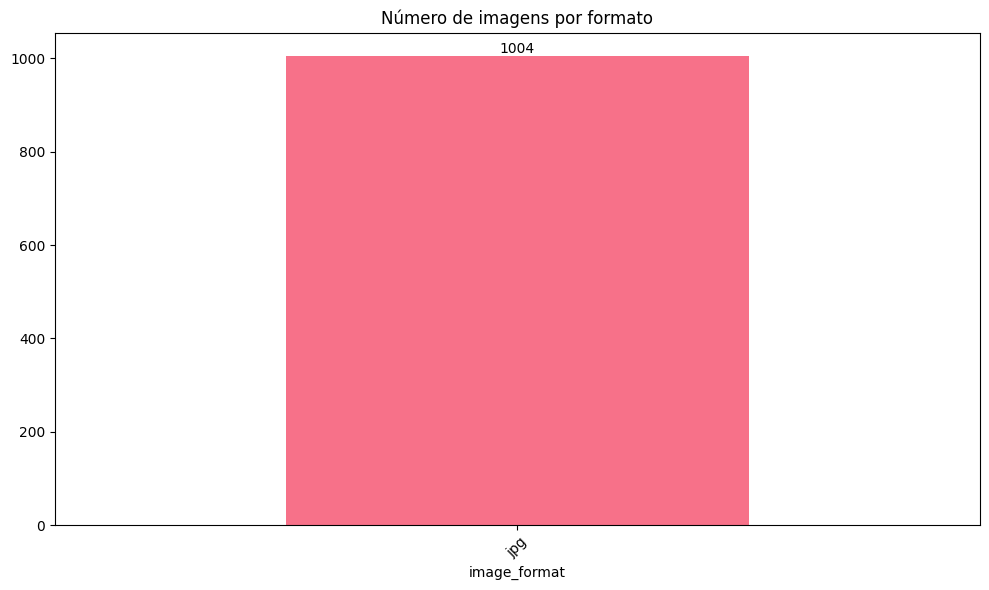


 Status de integridade:
  Total de imagens: 2098
  Imagens válidas: 1004
  Imagens corrompidas: 0
  Taxa de sucesso: 47.9%


In [41]:
print(f"\n MÓDULO 4: Verificação da integridade dos arquivos")
print("=" * 55)

def verificar_integridade():
    """Analisa a integridade dos arquivos, baseado no modelo do professor"""

    if df is None or len(df) == 0:
        print(" DataFrame não está disponível")
        return

    print(" Informações estatísticas das dimensões das imagens:")

    # Estatísticas das dimensões
    stats_cols = ['width', 'height', 'channels', 'num_classes']
    stats_df = df[stats_cols].describe().loc[['mean', 'std', 'min', 'max']]
    print(stats_df)

    print(f"\n Quantidade de imagens por formato:")

    # Gráfico de formatos
    plt.figure(figsize=(10, 6))
    ax = df['image_format'].value_counts().plot(kind='bar', title='Número de imagens por formato')

    for p in ax.patches:
        ax.annotate(str(int(p.get_height())),
                    (p.get_x() + p.get_width() / 2, p.get_height()),
                    ha='center', va='bottom', fontsize=10)

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Informações sobre corrupção
    print(f"\n Status de integridade:")
    print(f"  Total de imagens: {len(df_completo) if df_completo is not None else 'N/A'}")
    print(f"  Imagens válidas: {len(df)}")
    print(f"  Imagens corrompidas: {df_completo['corrupted'].sum() if df_completo is not None else 'N/A'}")
    print(f"  Taxa de sucesso: {len(df)/len(df_completo)*100:.1f}%" if df_completo is not None else "N/A")

# Executar verificação
verificar_integridade()



# MÓDULO 5: VERIFICAR CONSISTÊNCIA DOS METADADOS  


 MÓDULO 5: Verificação da consistência dos metadados
 Distribuição das dimensões (Altura vs Largura):


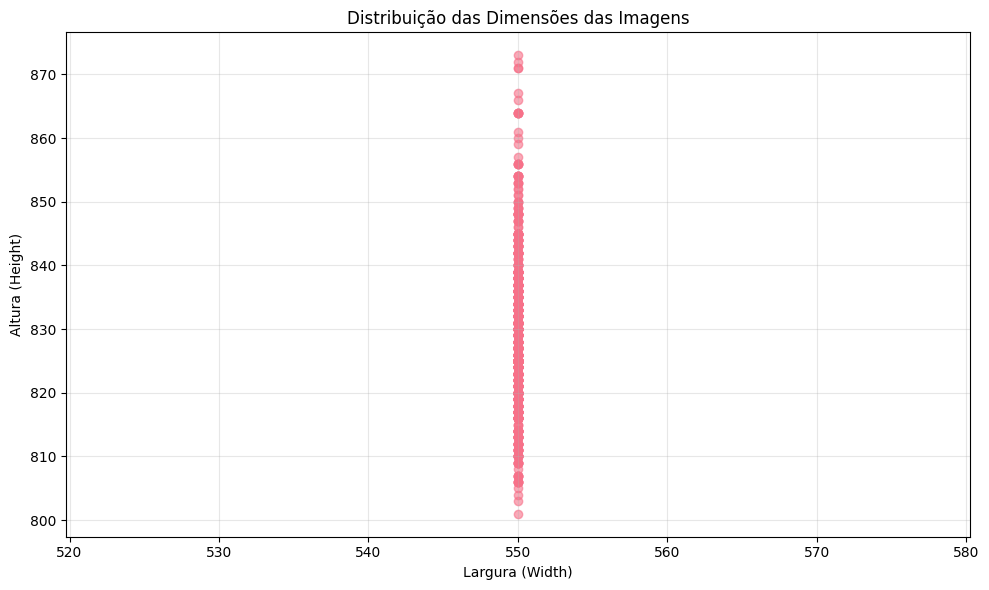


 Quantidade de informações nulas por coluna:
  Nenhum valor nulo encontrado!

 Estatísticas das classes por imagem:
  Média de classes por imagem: 7.24
  Mediana: 7.0
  Mínimo: 0
  Máximo: 13


In [42]:
print(f"\n MÓDULO 5: Verificação da consistência dos metadados")
print("=" * 60)

def verificar_consistencia():
    """Verifica consistência dos metadados"""

    print(" Distribuição das dimensões (Altura vs Largura):")

    plt.figure(figsize=(10, 6))
    plt.scatter(df['width'], df['height'], alpha=0.6)
    plt.xlabel('Largura (Width)')
    plt.ylabel('Altura (Height)')
    plt.title('Distribuição das Dimensões das Imagens')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    print(f"\n Quantidade de informações nulas por coluna:")
    null_counts = df.isnull().sum()
    for col, count in null_counts.items():
        if count > 0:
            print(f"  {col}: {count} valores nulos")

    if null_counts.sum() == 0:
        print("  Nenhum valor nulo encontrado!")

    print(f"\n Estatísticas das classes por imagem:")
    print(f"  Média de classes por imagem: {df['num_classes'].mean():.2f}")
    print(f"  Mediana: {df['num_classes'].median():.1f}")
    print(f"  Mínimo: {df['num_classes'].min()}")
    print(f"  Máximo: {df['num_classes'].max()}")

# Executar verificação
verificar_consistencia()

# MÓDULO 6: ANALISAR QUALIDADE DAS IMAGENS

🔧 EXECUTANDO ANÁLISE CORRIGIDA...
 Status de corrupção das imagens:
  Total de imagens corrompidas: 0
  Total de imagens: 2098
  Taxa de corrupção: 0.00%


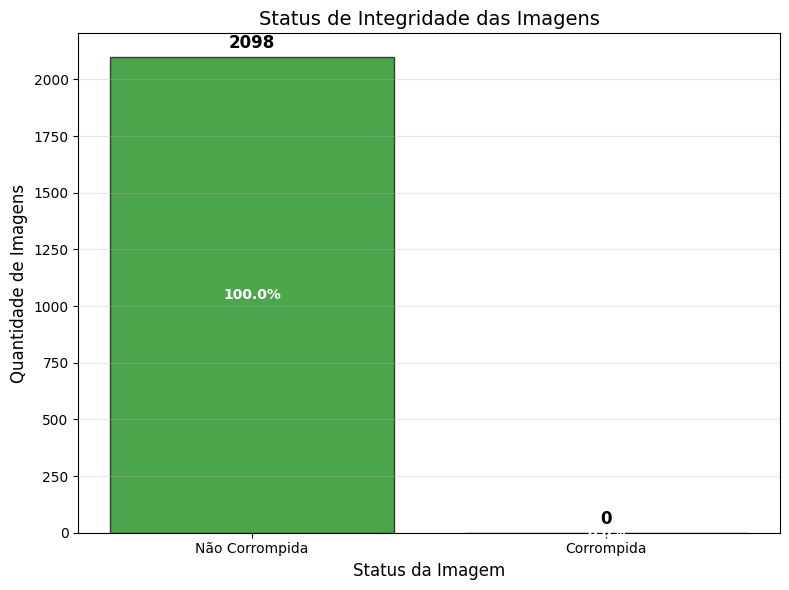


 Análise de dimensões:


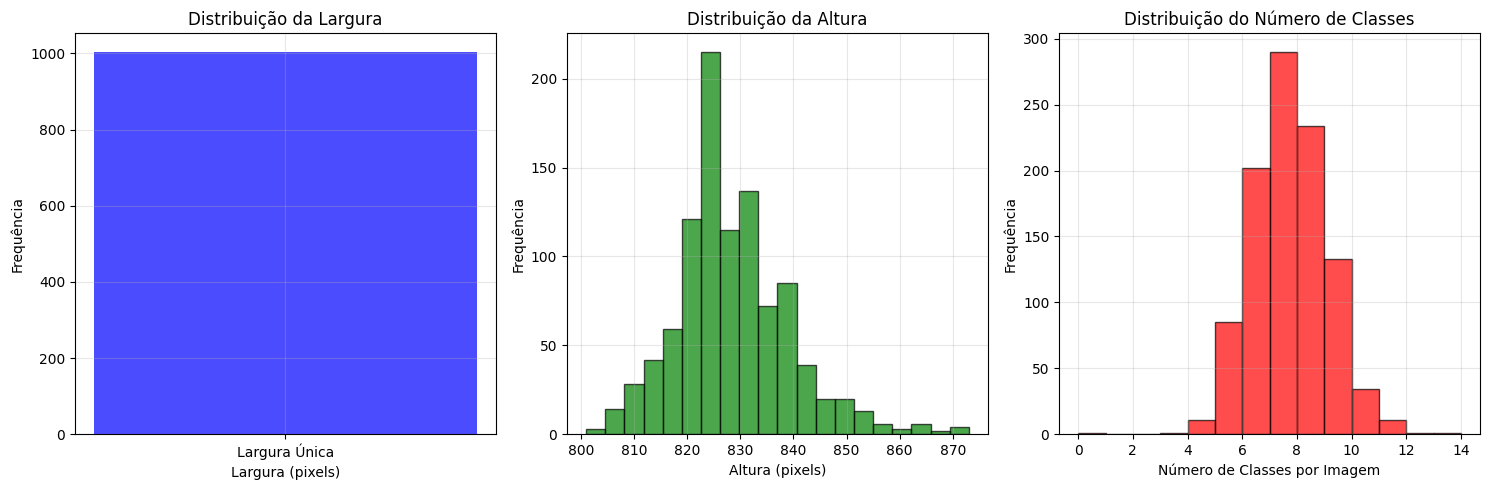

In [43]:
def analisar_qualidade_corrigido():
    """Versão corrigida da análise de qualidade"""

    print(" Status de corrupção das imagens:")

    if df_completo is not None:
        # Total de imagens corrompidas
        corrupted_count = df_completo['corrupted'].sum()
        total_count = len(df_completo)

        print(f"  Total de imagens corrompidas: {corrupted_count}")
        print(f"  Total de imagens: {total_count}")
        print(f"  Taxa de corrupção: {corrupted_count/total_count*100:.2f}%")

        # Gráfico de corrupção - VERSÃO CORRIGIDA
        plt.figure(figsize=(8, 6))

        # Contar valores manualmente
        nao_corrompidas = (df_completo['corrupted'] == False).sum()
        corrompidas = (df_completo['corrupted'] == True).sum()

        # Dados para o gráfico
        categorias = ['Não Corrompida', 'Corrompida']
        valores = [nao_corrompidas, corrompidas]
        cores = ['green', 'red']

        # Criar gráfico de barras
        bars = plt.bar(categorias, valores, color=cores, alpha=0.7, edgecolor='black')
        plt.title('Status de Integridade das Imagens', fontsize=14)
        plt.xlabel('Status da Imagem', fontsize=12)
        plt.ylabel('Quantidade de Imagens', fontsize=12)

        # Adicionar valores nas barras
        for bar, valor in zip(bars, valores):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + max(valores)*0.01,
                    f'{valor}', ha='center', va='bottom', fontsize=12, fontweight='bold')

        # Adicionar percentuais
        for bar, valor in zip(bars, valores):
            pct = valor/total_count*100
            plt.text(bar.get_x() + bar.get_width()/2., valor/2,
                    f'{pct:.1f}%', ha='center', va='center',
                    fontsize=10, color='white', fontweight='bold')

        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()

    print(f"\n Análise de dimensões:")

    # Verificar se há dados válidos para plotar
    if df is not None and len(df) > 0:
        # Filtrar dados válidos
        dados_validos = df.dropna(subset=['width', 'height', 'num_classes'])

        if len(dados_validos) > 0:
            # Distribuição de dimensões
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))

            # Largura
            if dados_validos['width'].nunique() > 1:
                axes[0].hist(dados_validos['width'], bins=min(20, dados_validos['width'].nunique()),
                           alpha=0.7, color='blue', edgecolor='black')
            else:
                axes[0].bar(['Largura Única'], [len(dados_validos)], color='blue', alpha=0.7)
            axes[0].set_title('Distribuição da Largura')
            axes[0].set_xlabel('Largura (pixels)')
            axes[0].set_ylabel('Frequência')
            axes[0].grid(alpha=0.3)

            # Altura
            if dados_validos['height'].nunique() > 1:
                axes[1].hist(dados_validos['height'], bins=min(20, dados_validos['height'].nunique()),
                           alpha=0.7, color='green', edgecolor='black')
            else:
                axes[1].bar(['Altura Única'], [len(dados_validos)], color='green', alpha=0.7)
            axes[1].set_title('Distribuição da Altura')
            axes[1].set_xlabel('Altura (pixels)')
            axes[1].set_ylabel('Frequência')
            axes[1].grid(alpha=0.3)

            # Número de classes
            max_classes = dados_validos['num_classes'].max()
            if max_classes > 0:
                bins = range(dados_validos['num_classes'].min(), max_classes + 2)
                axes[2].hist(dados_validos['num_classes'], bins=bins,
                           alpha=0.7, color='red', edgecolor='black')
            else:
                axes[2].bar(['Sem Classes'], [len(dados_validos)], color='red', alpha=0.7)
            axes[2].set_title('Distribuição do Número de Classes')
            axes[2].set_xlabel('Número de Classes por Imagem')
            axes[2].set_ylabel('Frequência')
            axes[2].grid(alpha=0.3)

            plt.tight_layout()
            plt.show()
        else:
            print(" Não há dados válidos suficientes para análise de dimensões")
    else:
        print(" DataFrame principal não está disponível")

# Executar versão corrigida
print("🔧 EXECUTANDO ANÁLISE CORRIGIDA...")
analisar_qualidade_corrigido()

# MÓDULO 7: VERIFICAR DISTRIBUIÇÃO DAS CLASSES


🏷️ MÓDULO 7: Verificação da distribuição das classes
📊 Estatísticas das classes:
  Total de instâncias: 7269
  Classes únicas: 54
  Imagens com classes: 1004

🔝 Top 15 classes mais comuns:
   1. skin            1003 ( 13.8%)
   2. hair             960 ( 13.2%)
   3. shoes            775 ( 10.7%)
   4. bag              443 (  6.1%)
   5. pants            302 (  4.2%)
   6. sunglasses       293 (  4.0%)
   7. dress            271 (  3.7%)
   8. purse            234 (  3.2%)
   9. coat             232 (  3.2%)
  10. accessories      223 (  3.1%)
  11. blouse           220 (  3.0%)
  12. belt             195 (  2.7%)
  13. shirt            182 (  2.5%)
  14. skirt            167 (  2.3%)
  15. jeans            155 (  2.1%)


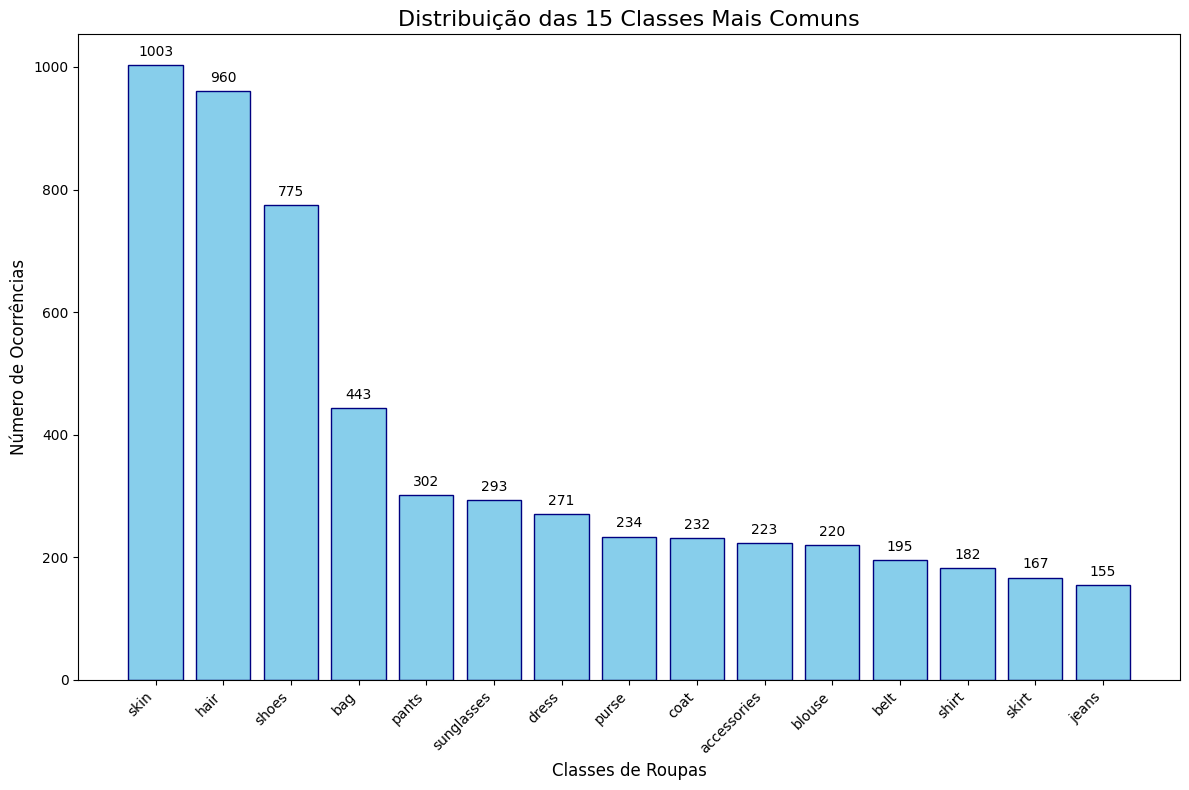

In [44]:
print(f"\n🏷️ MÓDULO 7: Verificação da distribuição das classes")
print("=" * 55)

def analisar_distribuicao_classes():
    """Analisa distribuição das classes de roupas"""

    # Coletar todas as classes
    todas_classes = []
    for classes_list in df['classes']:
        todas_classes.extend(classes_list)

    contador_classes = Counter(todas_classes)

    print(f"📊 Estatísticas das classes:")
    print(f"  Total de instâncias: {len(todas_classes)}")
    print(f"  Classes únicas: {len(contador_classes)}")
    print(f"  Imagens com classes: {len(df)}")

    # Top 15 classes mais comuns
    top_classes = contador_classes.most_common(15)

    print(f"\n🔝 Top 15 classes mais comuns:")
    for i, (classe, count) in enumerate(top_classes, 1):
        porcentagem = count/len(todas_classes)*100
        print(f"  {i:2d}. {classe:15} {count:4d} ({porcentagem:5.1f}%)")

    # Gráfico das classes principais
    plt.figure(figsize=(12, 8))
    classes_names = [item[0] for item in top_classes]
    classes_counts = [item[1] for item in top_classes]

    ax = plt.bar(range(len(classes_names)), classes_counts, color='skyblue', edgecolor='navy')
    plt.title('Distribuição das 15 Classes Mais Comuns', fontsize=16)
    plt.xlabel('Classes de Roupas', fontsize=12)
    plt.ylabel('Número de Ocorrências', fontsize=12)
    plt.xticks(range(len(classes_names)), classes_names, rotation=45, ha='right')

    # Adicionar valores nas barras
    for i, (bar, count) in enumerate(zip(ax, classes_counts)):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
                str(count), ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

    return contador_classes

# Executar análise
stats_classes = analisar_distribuicao_classes()

# MÓDULO 8: VERIFICAR DUPLICATAS

In [45]:

print(f"\n MÓDULO 8: Verificação de duplicatas")
print("=" * 40)

def verificar_duplicatas():
    """Verifica duplicatas usando hash perceptual, baseado no modelo do professor"""

    print(" Analisando duplicatas por hash perceptual...")

    # Filtrar apenas registros com hash válido
    df_com_hash = df[df['image_hash'].notna()].copy()

    # Quantidade de duplicatas
    duplicatas_count = df_com_hash['image_hash'].duplicated().sum()

    print(f"  Total de imagens analisadas: {len(df_com_hash)}")
    print(f"  Quantidade de imagens duplicadas: {duplicatas_count}")

    if duplicatas_count > 0:
        # DataFrame com duplicatas
        df_duplicated = df_com_hash[df_com_hash['image_hash'].duplicated(keep=False)].copy()

        print(f"\n Detalhes das imagens duplicadas:")
        print(df_duplicated[['image_id', 'image_hash', 'classes']].head(10))

        # Agrupar duplicatas
        duplicated_groups = {}
        for _, row in df_duplicated.iterrows():
            hash_val = row['image_hash']
            if hash_val not in duplicated_groups:
                duplicated_groups[hash_val] = []
            duplicated_groups[hash_val].append({
                'image_id': row['image_id'],
                'path': row['image_path_relative'],
                'classes': row['classes']
            })

        print(f"\n Grupos de duplicatas encontrados: {len(duplicated_groups)}")

        # Mostrar primeiro grupo como exemplo
        if duplicated_groups:
            first_hash = list(duplicated_groups.keys())[0]
            first_group = duplicated_groups[first_hash]

            print(f"\n📸 Exemplo de grupo duplicado (Hash: {first_hash}):")
            for item in first_group:
                print(f"  - ID: {item['image_id']}, Classes: {item['classes']}")

        # Análise de duplicatas por número de classes
        classes_counts = [len(row['classes']) for _, row in df_duplicated.iterrows()]

        plt.figure(figsize=(10, 6))
        plt.hist(classes_counts, bins=range(max(classes_counts)+2), alpha=0.7, color='orange')
        plt.title('Distribuição do Número de Classes nas Imagens Duplicadas')
        plt.xlabel('Número de Classes por Imagem Duplicada')
        plt.ylabel('Frequência')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        return df_duplicated, duplicated_groups

    else:
        print(" Nenhuma duplicata encontrada!")
        return None, None

# Executar verificação
df_duplicatas, grupos_duplicatas = verificar_duplicatas()


 MÓDULO 8: Verificação de duplicatas
 Analisando duplicatas por hash perceptual...
  Total de imagens analisadas: 1004
  Quantidade de imagens duplicadas: 0
 Nenhuma duplicata encontrada!


# MÓDULO 9: VISUALIZAÇÃO DE EXEMPLOS


🖼️ MÓDULO 9: Visualização de exemplos
🎨 Visualizando 4 exemplos aleatórios do dataset:


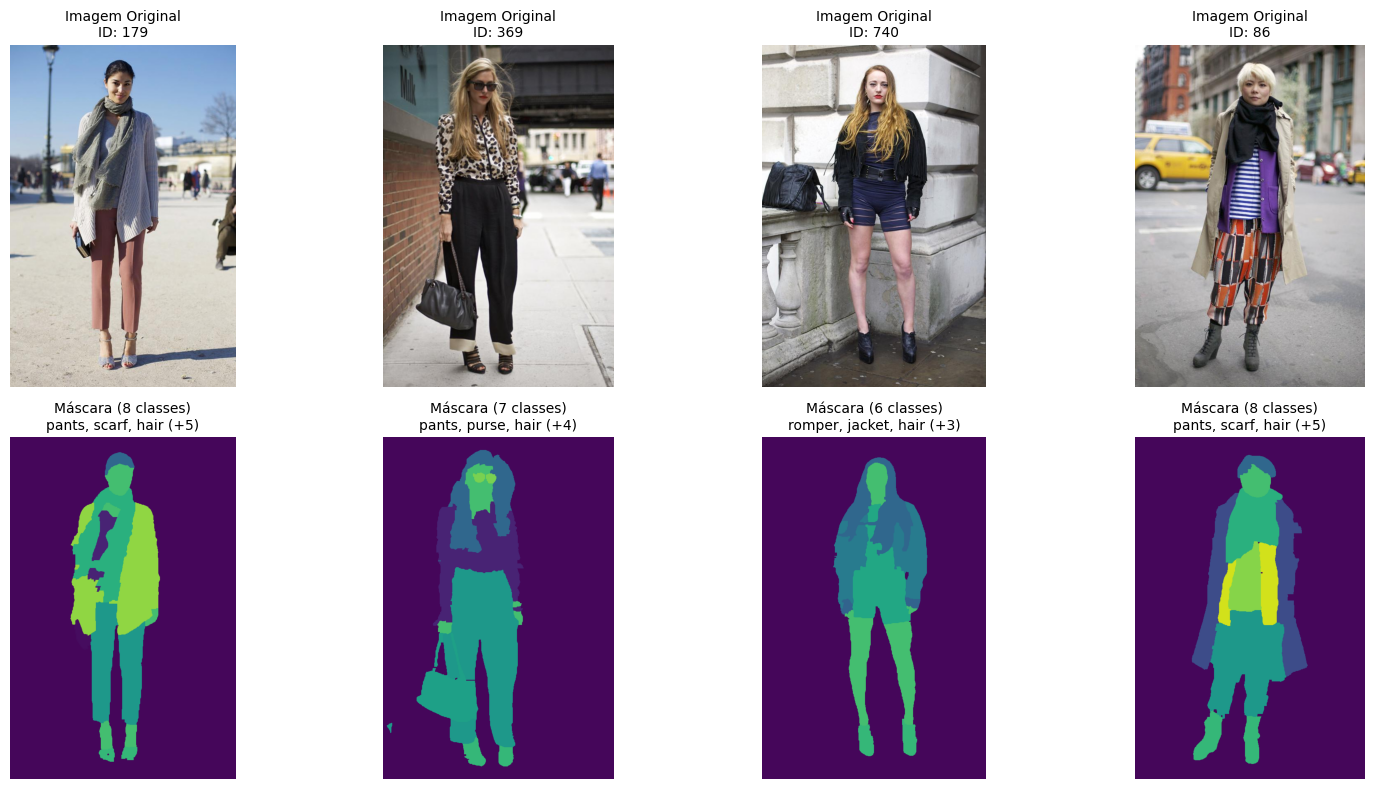

In [46]:
print(f"\n🖼️ MÓDULO 9: Visualização de exemplos")
print("=" * 40)

def visualizar_exemplos_dataset(num_exemplos=4):
    """Visualiza exemplos do dataset com suas máscaras"""

    print(f"🎨 Visualizando {num_exemplos} exemplos aleatórios do dataset:")

    # Selecionar exemplos aleatórios com pelo menos 2 classes
    df_com_classes = df[df['num_classes'] >= 2].copy()
    exemplos = df_com_classes.sample(n=min(num_exemplos, len(df_com_classes)))

    fig, axes = plt.subplots(2, num_exemplos, figsize=(4*num_exemplos, 8))

    for i, (_, row) in enumerate(exemplos.iterrows()):
        try:
            # Carregar imagem original
            img_original = cv2.imread(row['image_path_full'])
            img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)

            # Carregar máscara
            mask = Image.open(row['label_path_full'])

            # Plotar imagem original
            axes[0, i].imshow(img_original)
            axes[0, i].set_title(f'Imagem Original\nID: {row["image_id"]}', fontsize=10)
            axes[0, i].axis('off')

            # Plotar máscara
            axes[1, i].imshow(mask)
            classes_texto = ', '.join(row['classes'][:3])  # Mostrar apenas 3 primeiras
            if len(row['classes']) > 3:
                classes_texto += f" (+{len(row['classes'])-3})"
            axes[1, i].set_title(f'Máscara ({len(row["classes"])} classes)\n{classes_texto}', fontsize=10)
            axes[1, i].axis('off')

        except Exception as e:
            axes[0, i].text(0.5, 0.5, f'Erro ao\ncarregar\nimagem',
                           ha='center', va='center', transform=axes[0, i].transAxes)
            axes[1, i].text(0.5, 0.5, f'Erro: {str(e)[:20]}...',
                           ha='center', va='center', transform=axes[1, i].transAxes)
            axes[0, i].axis('off')
            axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

# Executar visualização
visualizar_exemplos_dataset(4)


# MÓDULO 10: RESUMO FINAL E SALVAMENTO


 MÓDULO 10: Resumo final, visualizações e salvamento
 RESUMO FINAL DO DATASET CLOTHING CO-PARSING
 Dataset processado com sucesso!
   Total de imagens válidas: 1004
   Imagens corrompidas: 0
   Taxa de sucesso: 47.9%

 Estatísticas de classes:
   Classes únicas encontradas: 54
   Total de instâncias de classes: 7269
   Média de classes por imagem: 7.24

 Dimensões das imagens:
   Largura média: 550px (±0)
   Altura média: 828px (±11)
   Formato mais comum: JPG

 Dataset processado salvo em: ./clothing-coparsing-dataset/dataset_processado_completo.csv
 Dataset para ML salvo em: ./clothing-coparsing-dataset/dataset_para_ml.csv
 Gerando visualizações do dataset...


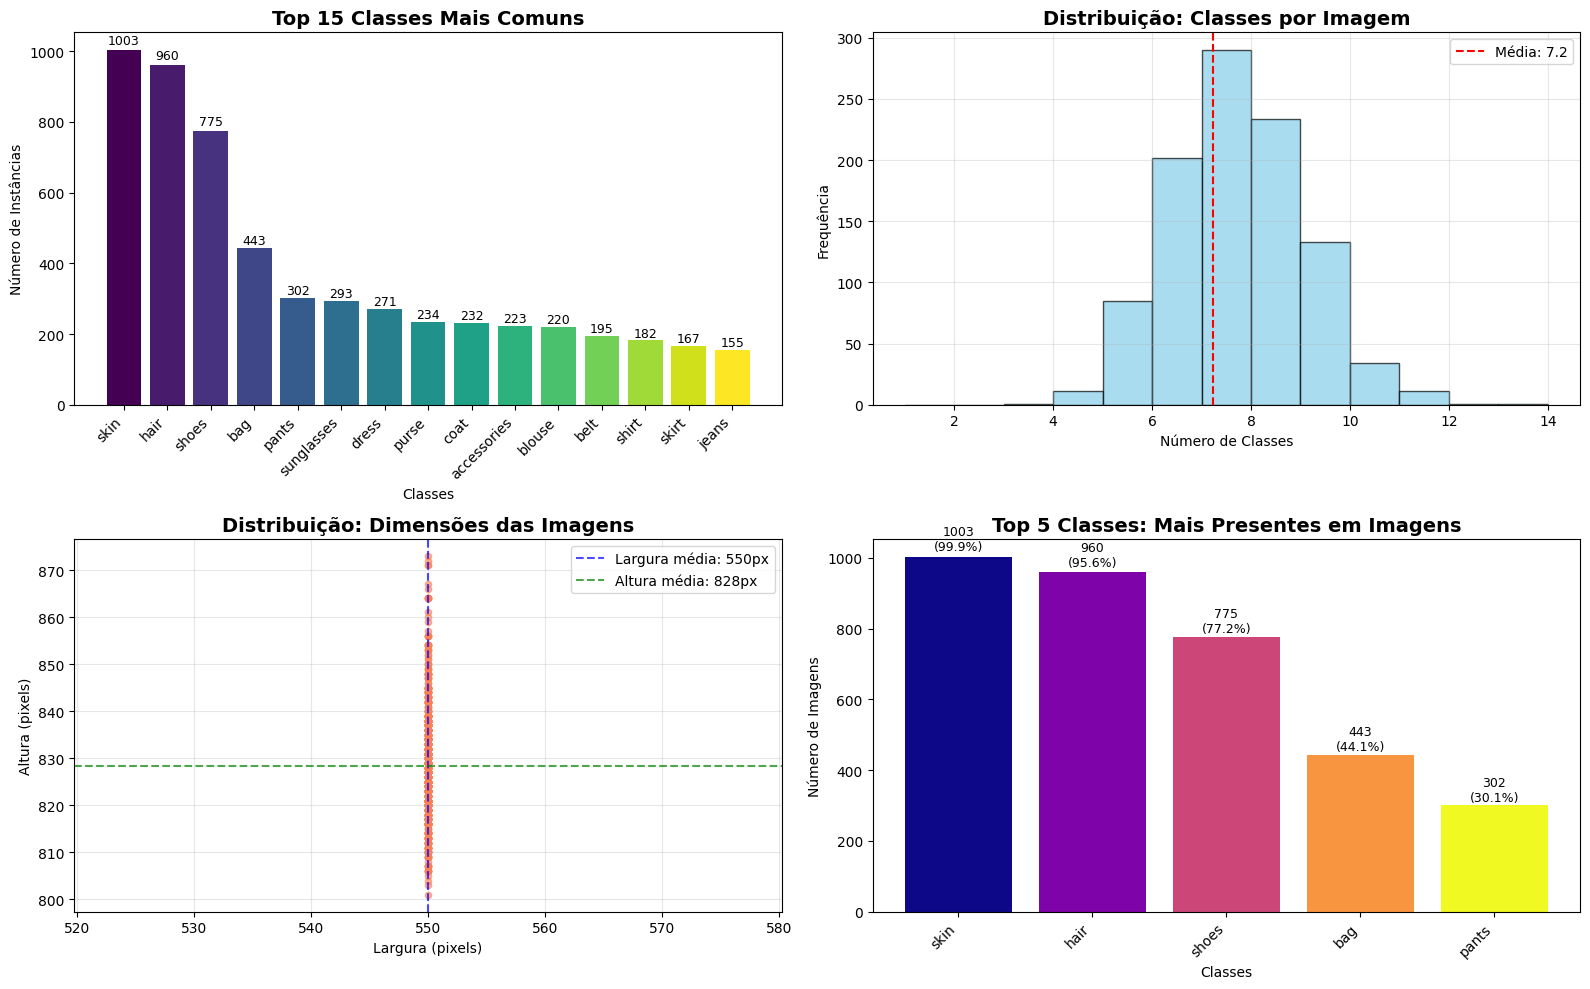

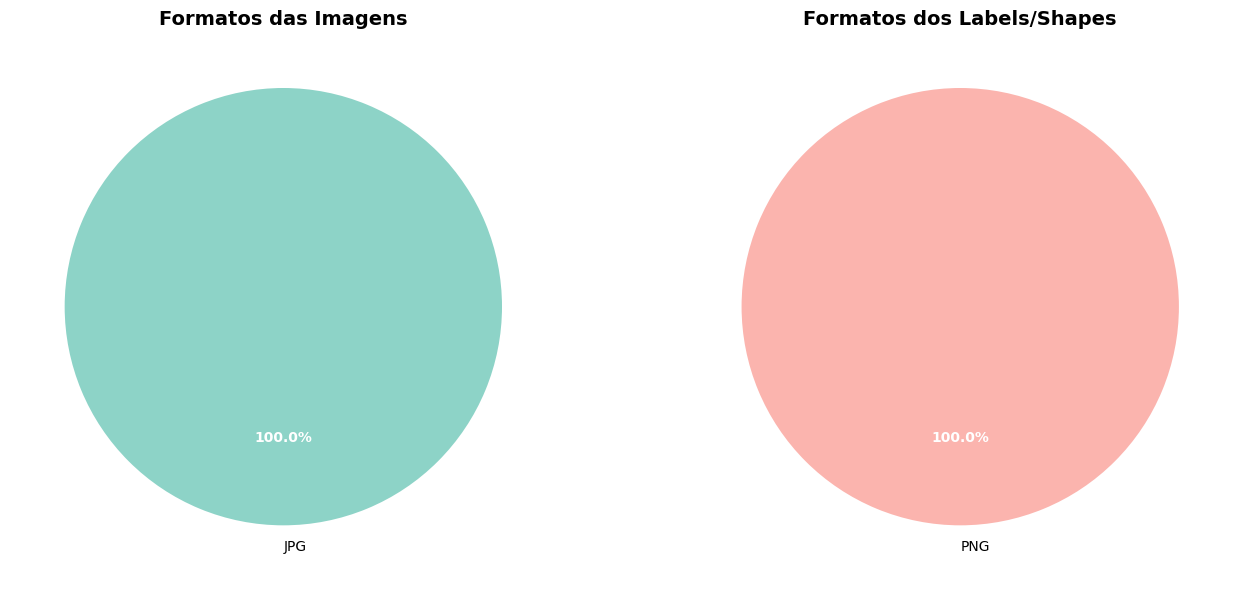

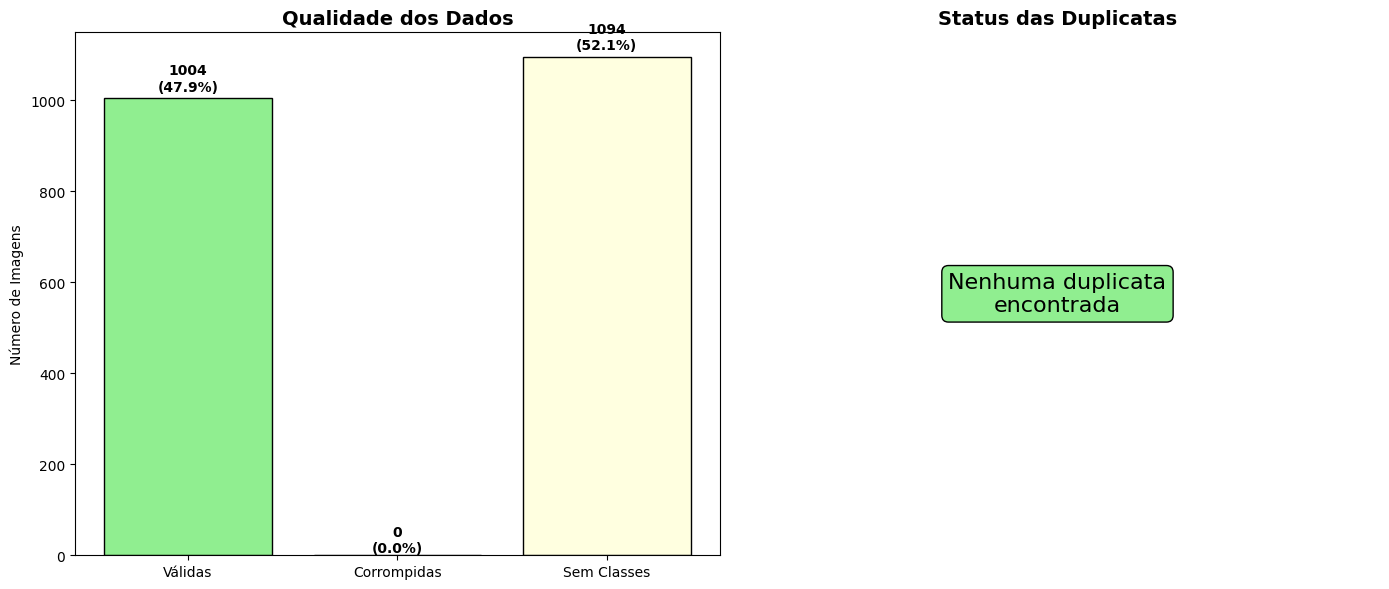

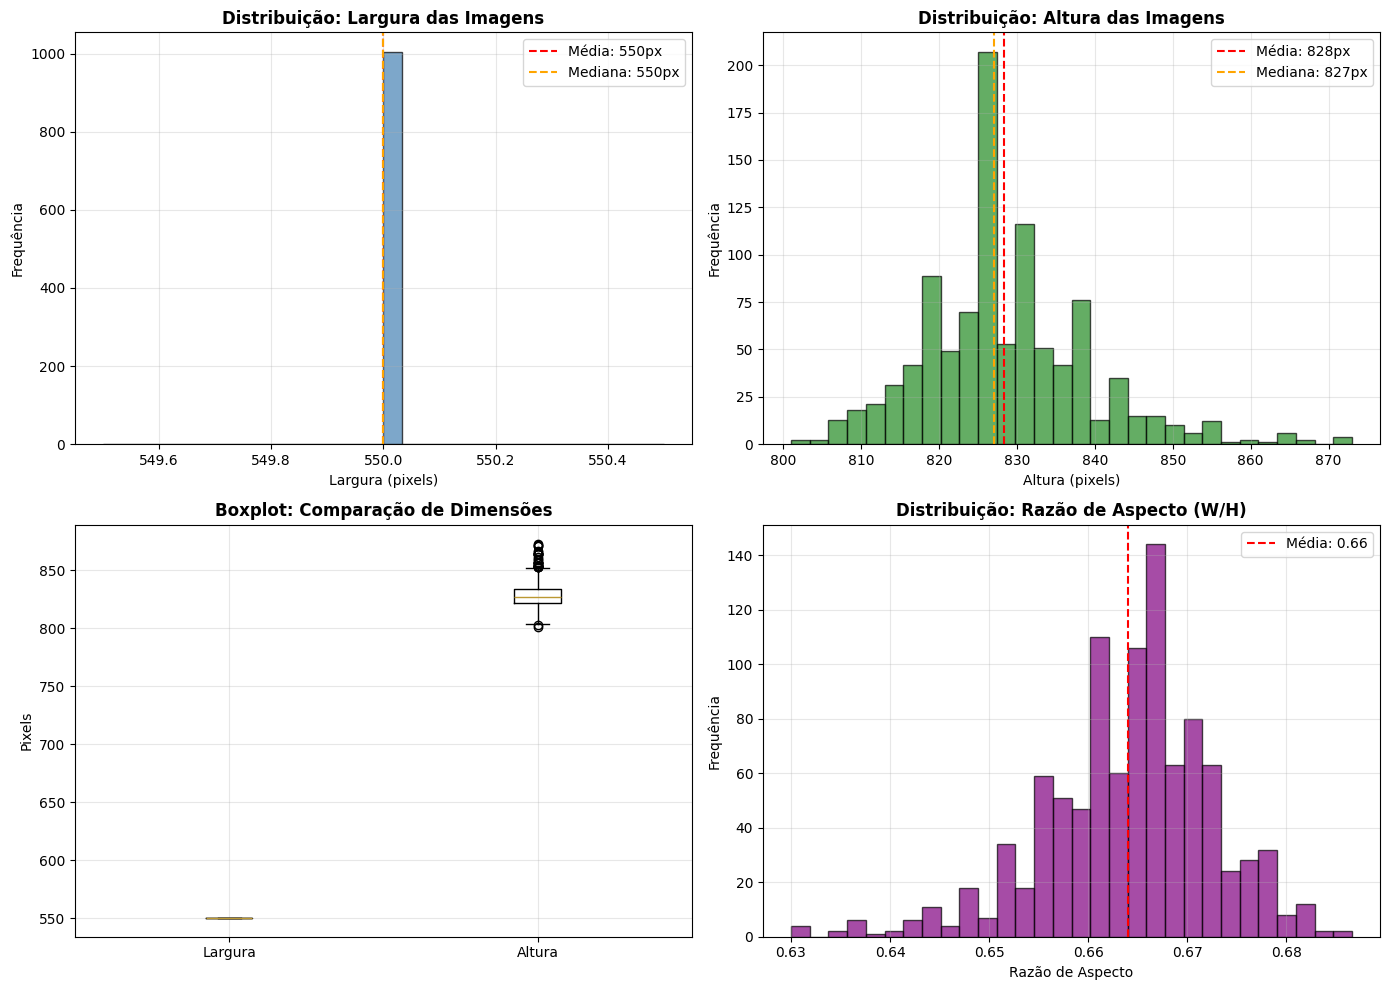

 Aviso: Coluna 'width' tem variância zero ou valores nulos - removida da correlação


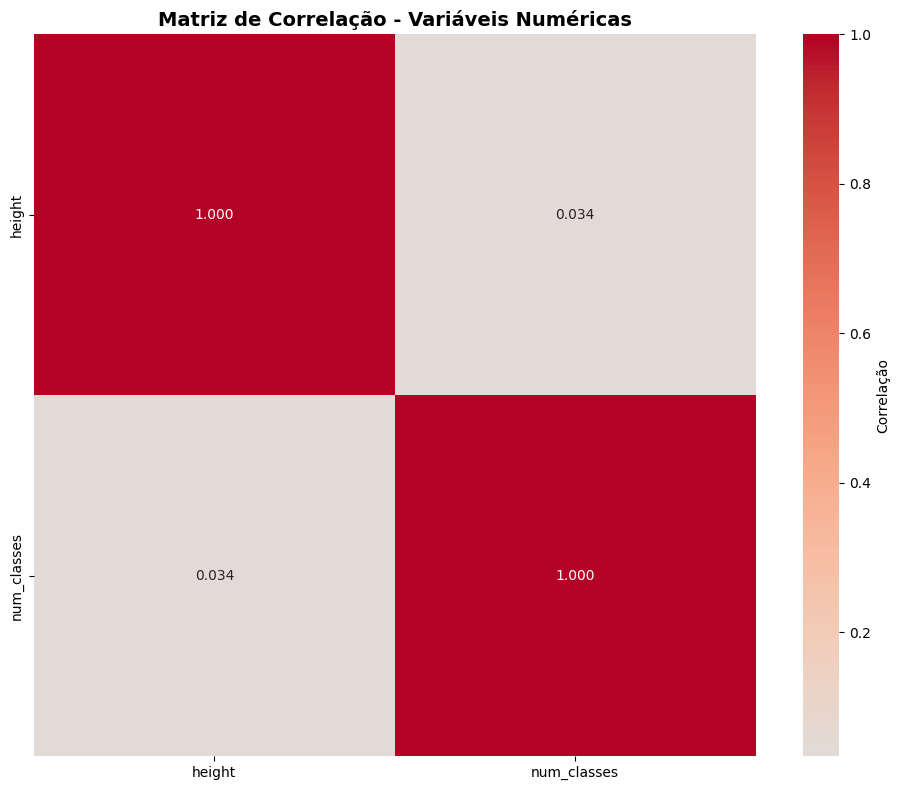

 Visualizações salvas em: ./clothing-coparsing-dataset/graficos_analise

 Gerando relatório detalhado...
 Relatório salvo em: ./clothing-coparsing-dataset/relatorio_detalhado.txt

 RESUMO DO RELATÓRIO:
RELATÓRIO DETALHADO - DATASET CLOTHING CO-PARSING

1. INFORMAÇÕES BÁSICAS
-------------------------
Dataset: Clothing Co-Parsing
Total de registros processados: 1004
Total de registros originais: 2098
Taxa de aproveitamento: 47.86%

2. ESTATÍSTICAS DAS IMAGENS
------------------------------
Dimensões médias: 550 x 828 pixels
Faixa de largura: 550 - 550 pixels
Faixa de altura: 801 - 873 pixels
Razão de aspecto média: 0.66
Formato principal: JPG

3. ESTATÍSTICAS DAS CLASSES
--------------------------------
Total de classes únicas: 54
Total de instâncias: 7269
Média por imagem: 7.24 classes
Classes por imagem (min-max): 0 - 13
...
[Relatório completo salvo em arquivo - 101 linhas total]

 Processamento completo! 
 - Arquivos CSV salvos
 - Relatório detalhado gerado
 - Visualizações criadas 

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from collections import Counter
import os

# Configuração para gráficos
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print(f"\n MÓDULO 10: Resumo final, visualizações e salvamento")
print("=" * 55)

def criar_visualizacoes():
    """Cria visualizações gráficas do dataset"""

    print(" Gerando visualizações do dataset...")

    if df is None or len(df) == 0:
        print(" Erro: DataFrame vazio, não é possível criar visualizações")
        return False

    # Criar diretório para gráficos
    graficos_dir = os.path.join(BASE_DIR, "graficos_analise")
    os.makedirs(graficos_dir, exist_ok=True)

    # 1. Distribuição de classes (Top 15)
    plt.figure(figsize=(16, 10))
    todas_classes = []
    for classes_list in df['classes']:
        todas_classes.extend(classes_list)

    contador_classes = Counter(todas_classes)
    top_classes = contador_classes.most_common(15)

    classes_names = [classe for classe, _ in top_classes]
    classes_counts = [count for _, count in top_classes]

    plt.subplot(2, 2, 1)
    bars = plt.bar(range(len(classes_names)), classes_counts, color=plt.cm.viridis(np.linspace(0, 1, len(classes_names))))
    plt.title('Top 15 Classes Mais Comuns', fontsize=14, fontweight='bold')
    plt.xlabel('Classes')
    plt.ylabel('Número de Instâncias')
    plt.xticks(range(len(classes_names)), classes_names, rotation=45, ha='right')

    # Adicionar valores nas barras
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{int(height)}', ha='center', va='bottom', fontsize=9)

    # Novo gráfico: Top 5 classes com mais imagens (frequência em imagens, não instâncias)
    plt.subplot(2, 2, 4)

    # Calcular frequência de cada classe em número de imagens
    classes_por_imagem = {}
    for _, row in df.iterrows():
        for classe in row['classes']:
            if classe not in classes_por_imagem:
                classes_por_imagem[classe] = 0
            classes_por_imagem[classe] += 1

    # Top 5 classes que aparecem em mais imagens
    top_classes_imagens = sorted(classes_por_imagem.items(), key=lambda x: x[1], reverse=True)[:5]

    classes_img_names = [classe for classe, _ in top_classes_imagens]
    classes_img_counts = [count for _, count in top_classes_imagens]

    bars2 = plt.bar(range(len(classes_img_names)), classes_img_counts,
                    color=plt.cm.plasma(np.linspace(0, 1, len(classes_img_names))))
    plt.title('Top 5 Classes: Mais Presentes em Imagens', fontsize=14, fontweight='bold')
    plt.xlabel('Classes')
    plt.ylabel('Número de Imagens')
    plt.xticks(range(len(classes_img_names)), classes_img_names, rotation=45, ha='right')

    # Adicionar valores e percentuais nas barras
    total_imagens = len(df)
    for i, bar in enumerate(bars2):
        height = bar.get_height()
        pct = height/total_imagens*100
        plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{int(height)}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=9)

    # 2. Distribuição do número de classes por imagem
    plt.subplot(2, 2, 2)
    plt.hist(df['num_classes'], bins=range(1, df['num_classes'].max()+2),
             alpha=0.7, color='skyblue', edgecolor='black')
    plt.title('Distribuição: Classes por Imagem', fontsize=14, fontweight='bold')
    plt.xlabel('Número de Classes')
    plt.ylabel('Frequência')
    plt.grid(True, alpha=0.3)

    # Adicionar linha da média
    media_classes = df['num_classes'].mean()
    plt.axvline(media_classes, color='red', linestyle='--',
                label=f'Média: {media_classes:.1f}')
    plt.legend()

    # 3. Distribuição de dimensões das imagens
    plt.subplot(2, 2, 3)
    plt.scatter(df['width'], df['height'], alpha=0.6, s=20, color='coral')
    plt.title('Distribuição: Dimensões das Imagens', fontsize=14, fontweight='bold')
    plt.xlabel('Largura (pixels)')
    plt.ylabel('Altura (pixels)')
    plt.grid(True, alpha=0.3)

    # Adicionar linhas das médias
    plt.axvline(df['width'].mean(), color='blue', linestyle='--', alpha=0.7,
                label=f'Largura média: {df["width"].mean():.0f}px')
    plt.axhline(df['height'].mean(), color='green', linestyle='--', alpha=0.7,
                label=f'Altura média: {df["height"].mean():.0f}px')
    plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(graficos_dir, '01_overview_dataset.png'),
                dpi=300, bbox_inches='tight')
    plt.show()

    # 4. Gráfico para distribuição de formatos (imagens e labels)
    plt.figure(figsize=(14, 6))

    # Subplot 1: Formatos das imagens
    plt.subplot(1, 2, 1)
    formato_counts_img = df['image_format'].value_counts()
    colors_img = plt.cm.Set3(np.linspace(0, 1, len(formato_counts_img)))
    wedges, texts, autotexts = plt.pie(formato_counts_img.values,
                                      labels=[f'{fmt.upper()}' for fmt in formato_counts_img.index],
                                      autopct='%1.1f%%', colors=colors_img, startangle=90)
    plt.title('Formatos das Imagens', fontsize=14, fontweight='bold')

    # Melhorar aparência dos textos
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')

    # Subplot 2: Formatos dos labels/shapes (se existir coluna)
    plt.subplot(1, 2, 2)
    if 'label_format' in df.columns:
        formato_counts_label = df['label_format'].value_counts()
        colors_label = plt.cm.Pastel1(np.linspace(0, 1, len(formato_counts_label)))
        wedges2, texts2, autotexts2 = plt.pie(formato_counts_label.values,
                                             labels=[f'{fmt.upper()}' for fmt in formato_counts_label.index],
                                             autopct='%1.1f%%', colors=colors_label, startangle=90)
        plt.title('Formatos dos Labels/Shapes', fontsize=14, fontweight='bold')

        for autotext in autotexts2:
            autotext.set_color('white')
            autotext.set_fontweight('bold')
    else:
        # Se não há coluna de formato dos labels, vamos extrair da extensão do arquivo
        if 'label_path_relative' in df.columns:
            df_temp = df.dropna(subset=['label_path_relative'])
            if len(df_temp) > 0:
                label_extensions = df_temp['label_path_relative'].apply(lambda x: x.split('.')[-1].lower() if pd.notna(x) else 'unknown')
                formato_counts_label = label_extensions.value_counts()
                colors_label = plt.cm.Pastel1(np.linspace(0, 1, len(formato_counts_label)))
                wedges2, texts2, autotexts2 = plt.pie(formato_counts_label.values,
                                                     labels=[f'{fmt.upper()}' for fmt in formato_counts_label.index],
                                                     autopct='%1.1f%%', colors=colors_label, startangle=90)
                plt.title('Formatos dos Labels/Shapes', fontsize=14, fontweight='bold')

                for autotext in autotexts2:
                    autotext.set_color('white')
                    autotext.set_fontweight('bold')
            else:
                plt.text(0.5, 0.5, 'Labels não\ndisponíveis', ha='center', va='center',
                        fontsize=16, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
                plt.title('Formatos dos Labels/Shapes', fontsize=14, fontweight='bold')
                plt.axis('off')
        else:
            plt.text(0.5, 0.5, 'Labels não\ndisponíveis', ha='center', va='center',
                    fontsize=16, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
            plt.title('Formatos dos Labels/Shapes', fontsize=14, fontweight='bold')
            plt.axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(graficos_dir, '01b_formatos_completos.png'),
                dpi=300, bbox_inches='tight')
    plt.show()

    # 5. Gráfico de qualidade dos dados
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    # Estatísticas de qualidade
    if df_completo is not None:
        corrupted = df_completo['corrupted'].sum()
        sem_classes = len(df_completo) - len(df)
        validas = len(df)

        categories = ['Válidas', 'Corrompidas', 'Sem Classes']
        values = [validas, corrupted, sem_classes]
        colors = ['lightgreen', 'lightcoral', 'lightyellow']

        bars = plt.bar(categories, values, color=colors, edgecolor='black')
        plt.title('Qualidade dos Dados', fontsize=14, fontweight='bold')
        plt.ylabel('Número de Imagens')

        # Adicionar percentuais
        total = sum(values)
        for i, (bar, value) in enumerate(zip(bars, values)):
            height = bar.get_height()
            pct = value/total*100 if total > 0 else 0
            plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                    f'{value}\n({pct:.1f}%)', ha='center', va='bottom', fontweight='bold')

    plt.subplot(1, 2, 2)
    # Distribuição de duplicatas (se houver)
    if df_duplicatas is not None and len(df_duplicatas) > 0:
        unicas = len(df) - len(df_duplicatas)
        duplicadas = len(df_duplicatas)

        plt.pie([unicas, duplicadas], labels=['Únicas', 'Duplicadas'],
                autopct='%1.1f%%', colors=['lightblue', 'orange'], startangle=90)
        plt.title('Duplicatas no Dataset', fontsize=14, fontweight='bold')
    else:
        plt.text(0.5, 0.5, 'Nenhuma duplicata\nencontrada',
                ha='center', va='center', fontsize=16,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen"))
        plt.title('Status das Duplicatas', fontsize=14, fontweight='bold')
        plt.axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(graficos_dir, '02_qualidade_dados.png'),
                dpi=300, bbox_inches='tight')
    plt.show()

    # 6. Análise detalhada de dimensões
    plt.figure(figsize=(14, 10))

    # Histograma de larguras
    plt.subplot(2, 2, 1)
    plt.hist(df['width'], bins=30, alpha=0.7, color='steelblue', edgecolor='black')
    plt.title('Distribuição: Largura das Imagens', fontsize=12, fontweight='bold')
    plt.xlabel('Largura (pixels)')
    plt.ylabel('Frequência')
    plt.axvline(df['width'].mean(), color='red', linestyle='--',
                label=f'Média: {df["width"].mean():.0f}px')
    plt.axvline(df['width'].median(), color='orange', linestyle='--',
                label=f'Mediana: {df["width"].median():.0f}px')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Histograma de alturas
    plt.subplot(2, 2, 2)
    plt.hist(df['height'], bins=30, alpha=0.7, color='forestgreen', edgecolor='black')
    plt.title('Distribuição: Altura das Imagens', fontsize=12, fontweight='bold')
    plt.xlabel('Altura (pixels)')
    plt.ylabel('Frequência')
    plt.axvline(df['height'].mean(), color='red', linestyle='--',
                label=f'Média: {df["height"].mean():.0f}px')
    plt.axvline(df['height'].median(), color='orange', linestyle='--',
                label=f'Mediana: {df["height"].median():.0f}px')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Boxplot comparativo
    plt.subplot(2, 2, 3)
    data_dims = [df['width'], df['height']]
    plt.boxplot(data_dims, labels=['Largura', 'Altura'])
    plt.title('Boxplot: Comparação de Dimensões', fontsize=12, fontweight='bold')
    plt.ylabel('Pixels')
    plt.grid(True, alpha=0.3)

    # Razão aspecto
    plt.subplot(2, 2, 4)
    aspect_ratio = df['width'] / df['height']
    plt.hist(aspect_ratio, bins=30, alpha=0.7, color='purple', edgecolor='black')
    plt.title('Distribuição: Razão de Aspecto (W/H)', fontsize=12, fontweight='bold')
    plt.xlabel('Razão de Aspecto')
    plt.ylabel('Frequência')
    plt.axvline(aspect_ratio.mean(), color='red', linestyle='--',
                label=f'Média: {aspect_ratio.mean():.2f}')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(graficos_dir, '03_analise_dimensoes.png'),
                dpi=300, bbox_inches='tight')
    plt.show()

    # 7. Heatmap de correlações (com tratamento de erros)
    plt.figure(figsize=(10, 8))

    try:
        # Criar matriz de correlação com variáveis numéricas
        numeric_cols = ['width', 'height', 'num_classes']

        # Verificar se as colunas existem e têm variância
        available_cols = []
        for col in numeric_cols:
            if col in df.columns:
                if df[col].std() > 0 and not df[col].isnull().all():  # Verificar se há variância
                    available_cols.append(col)
                else:
                    print(f" Aviso: Coluna '{col}' tem variância zero ou valores nulos - removida da correlação")

        if len(available_cols) >= 2:
            # Calcular correlação apenas com colunas válidas
            corr_data = df[available_cols].copy()

            # Remover linhas com valores NaN
            corr_data = corr_data.dropna()

            if len(corr_data) > 1:
                corr_matrix = corr_data.corr()

                # Verificar se a matriz tem valores válidos
                if not corr_matrix.isnull().all().all():
                    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
                                square=True, fmt='.3f', cbar_kws={'label': 'Correlação'},
                                xticklabels=True, yticklabels=True)
                    plt.title('Matriz de Correlação - Variáveis Numéricas', fontsize=14, fontweight='bold')
                else:
                    plt.text(0.5, 0.5, 'Dados insuficientes\npara correlação', ha='center', va='center',
                            fontsize=16, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow"))
                    plt.title('Matriz de Correlação - Dados Insuficientes', fontsize=14, fontweight='bold')
                    plt.axis('off')
            else:
                plt.text(0.5, 0.5, 'Dados insuficientes\npara correlação\n(muito poucos registros)',
                        ha='center', va='center', fontsize=16,
                        bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow"))
                plt.title('Matriz de Correlação - Dados Insuficientes', fontsize=14, fontweight='bold')
                plt.axis('off')
        else:
            plt.text(0.5, 0.5, f'Variáveis insuficientes\npara correlação\n(apenas {len(available_cols)} válidas)',
                    ha='center', va='center', fontsize=16,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow"))
            plt.title('Matriz de Correlação - Variáveis Insuficientes', fontsize=14, fontweight='bold')
            plt.axis('off')

    except Exception as e:
        print(f" Erro ao calcular correlações: {e}")
        plt.text(0.5, 0.5, f'Erro ao calcular\ncorrelações:\n{str(e)[:50]}...',
                ha='center', va='center', fontsize=12,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral"))
        plt.title('Matriz de Correlação - Erro', fontsize=14, fontweight='bold')
        plt.axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(graficos_dir, '04_correlacoes.png'),
                dpi=300, bbox_inches='tight')
    plt.show()

    print(f" Visualizações salvas em: {graficos_dir}")
    return True

def gerar_resumo_final():
    """Gera resumo final do dataset processado"""

    print(" RESUMO FINAL DO DATASET CLOTHING CO-PARSING")
    print("=" * 55)

    if df is not None and len(df) > 0:
        # Estatísticas gerais
        print(f" Dataset processado com sucesso!")
        print(f"   Total de imagens válidas: {len(df)}")
        print(f"   Imagens corrompidas: {df_completo['corrupted'].sum() if df_completo is not None else 'N/A'}")
        print(f"   Taxa de sucesso: {len(df)/len(df_completo)*100:.1f}%" if df_completo is not None else "N/A")

        # Estatísticas de classes
        todas_classes = []
        for classes_list in df['classes']:
            todas_classes.extend(classes_list)

        print(f"\n Estatísticas de classes:")
        print(f"   Classes únicas encontradas: {len(set(todas_classes))}")
        print(f"   Total de instâncias de classes: {len(todas_classes)}")
        print(f"   Média de classes por imagem: {len(todas_classes)/len(df):.2f}")

        # Estatísticas de dimensões
        print(f"\n Dimensões das imagens:")
        print(f"   Largura média: {df['width'].mean():.0f}px (±{df['width'].std():.0f})")
        print(f"   Altura média: {df['height'].mean():.0f}px (±{df['height'].std():.0f})")
        print(f"   Formato mais comum: {df['image_format'].mode()[0].upper()}")

        # Estatísticas de duplicatas
        if df_duplicatas is not None:
            print(f"\n Duplicatas:")
            print(f"   Imagens duplicadas encontradas: {len(df_duplicatas)}")
            print(f"   Taxa de duplicação: {len(df_duplicatas)/len(df)*100:.2f}%")

        # Salvar DataFrame processado
        output_path = os.path.join(BASE_DIR, "dataset_processado_completo.csv")
        df.to_csv(output_path, index=False)
        print(f"\n Dataset processado salvo em: {output_path}")

        # Salvar apenas caminhos e classes para uso em ML
        df_ml = df[['image_path_relative', 'label_path_relative', 'classes', 'num_classes', 'width', 'height']].copy()
        ml_path = os.path.join(BASE_DIR, "dataset_para_ml.csv")
        df_ml.to_csv(ml_path, index=False)
        print(f" Dataset para ML salvo em: {ml_path}")

        # Gerar visualizações
        criar_visualizacoes()

        return True
    else:
        print(" Erro: DataFrame não foi criado corretamente")
        return False

def criar_relatorio_detalhado():
    """Cria um relatório detalhado em texto"""

    print(f"\n Gerando relatório detalhado...")

    relatorio = []
    relatorio.append("="*60)
    relatorio.append("RELATÓRIO DETALHADO - DATASET CLOTHING CO-PARSING")
    relatorio.append("="*60)
    relatorio.append("")

    # Informações básicas
    relatorio.append("1. INFORMAÇÕES BÁSICAS")
    relatorio.append("-" * 25)
    relatorio.append(f"Dataset: Clothing Co-Parsing")
    relatorio.append(f"Total de registros processados: {len(df) if df is not None else 0}")
    relatorio.append(f"Total de registros originais: {len(df_completo) if df_completo is not None else 0}")
    relatorio.append(f"Taxa de aproveitamento: {len(df)/len(df_completo)*100:.2f}%" if df_completo is not None and len(df_completo) > 0 else "N/A")
    relatorio.append("")

    if df is not None and len(df) > 0:
        # Estatísticas de imagens
        relatorio.append("2. ESTATÍSTICAS DAS IMAGENS")
        relatorio.append("-" * 30)
        relatorio.append(f"Dimensões médias: {df['width'].mean():.0f} x {df['height'].mean():.0f} pixels")
        relatorio.append(f"Faixa de largura: {df['width'].min()} - {df['width'].max()} pixels")
        relatorio.append(f"Faixa de altura: {df['height'].min()} - {df['height'].max()} pixels")
        relatorio.append(f"Razão de aspecto média: {(df['width']/df['height']).mean():.2f}")
        relatorio.append(f"Formato principal: {df['image_format'].mode()[0].upper()}")
        relatorio.append("")

        # Estatísticas de classes
        todas_classes = []
        for classes_list in df['classes']:
            todas_classes.extend(classes_list)

        contador_classes = Counter(todas_classes)

        relatorio.append("3. ESTATÍSTICAS DAS CLASSES")
        relatorio.append("-" * 32)
        relatorio.append(f"Total de classes únicas: {len(contador_classes)}")
        relatorio.append(f"Total de instâncias: {len(todas_classes)}")
        relatorio.append(f"Média por imagem: {len(todas_classes)/len(df):.2f} classes")
        relatorio.append(f"Classes por imagem (min-max): {df['num_classes'].min()} - {df['num_classes'].max()}")
        relatorio.append("")

        # Top 15 classes por instâncias e Top 5 por presença em imagens
        relatorio.append("4. ANÁLISE DETALHADA DAS CLASSES")
        relatorio.append("-" * 40)
        relatorio.append("")
        relatorio.append("4.1 TOP 15 CLASSES POR NÚMERO DE INSTÂNCIAS")
        relatorio.append("-" * 45)
        for i, (classe, count) in enumerate(contador_classes.most_common(15), 1):
            porcentagem = count/len(todas_classes)*100
            relatorio.append(f"{i:2d}. {classe:20} {count:4d} instâncias ({porcentagem:5.1f}%)")
        relatorio.append("")

        # Calcular frequência por imagens
        classes_por_imagem = {}
        for _, row in df.iterrows():
            for classe in row['classes']:
                if classe not in classes_por_imagem:
                    classes_por_imagem[classe] = 0
                classes_por_imagem[classe] += 1

        top_classes_imagens = sorted(classes_por_imagem.items(), key=lambda x: x[1], reverse=True)[:5]

        relatorio.append("4.2 TOP 5 CLASSES POR PRESENÇA EM IMAGENS")
        relatorio.append("-" * 42)
        total_imagens = len(df)
        for i, (classe, count) in enumerate(top_classes_imagens, 1):
            porcentagem = count/total_imagens*100
            relatorio.append(f"{i}. {classe:20} {count:4d} imagens ({porcentagem:5.1f}%)")
        relatorio.append("")

        # Qualidade dos dados
        relatorio.append("5. QUALIDADE DOS DADOS")
        relatorio.append("-" * 25)
        relatorio.append(f"Imagens corrompidas: {df_completo['corrupted'].sum() if df_completo is not None else 0}")
        relatorio.append(f"Imagens sem classes: {len(df_completo) - len(df) if df_completo is not None else 0}")
        relatorio.append(f"Valores nulos: {df.isnull().sum().sum()}")

        if df_duplicatas is not None:
            relatorio.append(f"Duplicatas encontradas: {len(df_duplicatas)}")
        else:
            relatorio.append("Duplicatas encontradas: 0")
        relatorio.append("")

        # Distribuição de formatos (imagens e labels)
        relatorio.append("6. DISTRIBUIÇÃO DE FORMATOS")
        relatorio.append("-" * 32)
        relatorio.append("6.1 FORMATOS DAS IMAGENS:")
        for formato, count in df['image_format'].value_counts().items():
            porcentagem = count/len(df)*100
            relatorio.append(f"    {formato.upper():4}: {count:4d} ({porcentagem:5.1f}%)")

        relatorio.append("")
        relatorio.append("6.2 FORMATOS DOS LABELS/SHAPES:")

        # Verificar se há coluna de formato dos labels
        if 'label_format' in df.columns:
            for formato, count in df['label_format'].value_counts().items():
                porcentagem = count/len(df)*100
                relatorio.append(f"    {formato.upper():4}: {count:4d} ({porcentagem:5.1f}%)")
        elif 'label_path_relative' in df.columns:
            df_temp = df.dropna(subset=['label_path_relative'])
            if len(df_temp) > 0:
                label_extensions = df_temp['label_path_relative'].apply(lambda x: x.split('.')[-1].lower() if pd.notna(x) else 'unknown')
                for formato, count in label_extensions.value_counts().items():
                    porcentagem = count/len(df_temp)*100
                    relatorio.append(f"    {formato.upper():4}: {count:4d} ({porcentagem:5.1f}%)")
            else:
                relatorio.append("    Nenhum label disponível")
        else:
            relatorio.append("    Coluna de labels não encontrada")
        relatorio.append("")

        # Análise estatística avançada
        relatorio.append("7. ANÁLISE ESTATÍSTICA AVANÇADA")
        relatorio.append("-" * 38)
        relatorio.append(f"Largura - Média: {df['width'].mean():.1f}, Mediana: {df['width'].median():.1f}, Desvio: {df['width'].std():.1f}")
        relatorio.append(f"Altura - Média: {df['height'].mean():.1f}, Mediana: {df['height'].median():.1f}, Desvio: {df['height'].std():.1f}")
        relatorio.append(f"Classes - Média: {df['num_classes'].mean():.1f}, Mediana: {df['num_classes'].median():.1f}, Desvio: {df['num_classes'].std():.1f}")

        # Correlações com tratamento de erro
        try:
            # Verificar se as variáveis têm variância suficiente
            if df['width'].std() > 0 and df['height'].std() > 0:
                corr_w_h = df['width'].corr(df['height'])
                relatorio.append(f"Correlação Largura-Altura: {corr_w_h:.3f}")
            else:
                relatorio.append("Correlação Largura-Altura: N/A (variância insuficiente)")

            if df['width'].std() > 0 and df['num_classes'].std() > 0:
                corr_w_classes = df['width'].corr(df['num_classes'])
                relatorio.append(f"Correlação Largura-Classes: {corr_w_classes:.3f}")
            else:
                relatorio.append("Correlação Largura-Classes: N/A (variância insuficiente)")

            if df['height'].std() > 0 and df['num_classes'].std() > 0:
                corr_h_classes = df['height'].corr(df['num_classes'])
                relatorio.append(f"Correlação Altura-Classes: {corr_h_classes:.3f}")
            else:
                relatorio.append("Correlação Altura-Classes: N/A (variância insuficiente)")

        except Exception as e:
            relatorio.append(f"Erro no cálculo de correlações: {str(e)[:50]}...")

        relatorio.append("")

        # Recomendações aprimoradas
        relatorio.append("8. RECOMENDAÇÕES E INSIGHTS")
        relatorio.append("-" * 33)

        # Taxa de corrupção
        taxa_corrupcao = df_completo['corrupted'].sum()/len(df_completo)*100 if df_completo is not None else 0
        if taxa_corrupcao > 5:
            relatorio.append(f"  Alta taxa de corrupção ({taxa_corrupcao:.1f}%) - investigar qualidade")
        else:
            relatorio.append(f" Taxa de corrupção aceitável ({taxa_corrupcao:.1f}%)")

        # Distribuição de classes
        if len(contador_classes) > 30:
            relatorio.append(f"  Muitas classes ({len(contador_classes)}) - considerar agrupamento")
        else:
            relatorio.append(f" Número de classes gerenciável ({len(contador_classes)})")

        # Duplicatas
        if df_duplicatas is not None and len(df_duplicatas) > len(df)*0.1:
            relatorio.append(f"  Muitas duplicatas ({len(df_duplicatas)}) - considerar remoção")
        else:
            relatorio.append(" Poucas duplicatas encontradas")

        # Dimensões
        cv_width = df['width'].std() / df['width'].mean()
        cv_height = df['height'].std() / df['height'].mean()

        if cv_width > 0.3 or cv_height > 0.3:
            relatorio.append(f"  Grande variação nas dimensões (CV: {cv_width:.2f}, {cv_height:.2f})")
        else:
            relatorio.append(" Dimensões relativamente consistentes")

        # Razão de aspecto
        aspect_ratios = df['width'] / df['height']
        if aspect_ratios.std() > 0.5:
            relatorio.append("  Grande variação na razão de aspecto")
        else:
            relatorio.append(" Razão de aspecto consistente")

        relatorio.append("")
        relatorio.append("9. ARQUIVOS GERADOS")
        relatorio.append("-" * 20)
        relatorio.append(" - dataset_processado_completo.csv")
        relatorio.append(" - dataset_para_ml.csv")
        relatorio.append(" - relatorio_detalhado.txt")
        relatorio.append(" - graficos_analise/01_overview_dataset.png")
        relatorio.append(" - graficos_analise/01b_formatos_completos.png")
        relatorio.append(" - graficos_analise/02_qualidade_dados.png")
        relatorio.append(" - graficos_analise/03_analise_dimensoes.png")
        relatorio.append(" - graficos_analise/04_correlacoes.png")

    relatorio.append("")
    relatorio.append("="*60)
    relatorio.append("Fim do Relatório")
    relatorio.append("="*60)

    # Salvar relatório
    relatorio_path = os.path.join(BASE_DIR, "relatorio_detalhado.txt")
    with open(relatorio_path, 'w', encoding='utf-8') as f:
        f.write('\n'.join(relatorio))

    print(f" Relatório salvo em: {relatorio_path}")

    # Mostrar resumo na tela
    print(f"\n RESUMO DO RELATÓRIO:")
    for linha in relatorio[:25]:  # Mostrar primeiras 25 linhas
        print(linha)

    if len(relatorio) > 25:
        print("...")
        print(f"[Relatório completo salvo em arquivo - {len(relatorio)} linhas total]")

# Executar resumo final (agora inclui visualizações)
sucesso = gerar_resumo_final()

# Executar criação do relatório detalhado
if sucesso:
    criar_relatorio_detalhado()

print(f"\n Processamento completo! ")
print(f" - Arquivos CSV salvos")
print(f" - Relatório detalhado gerado")
print(f" - Visualizações criadas na pasta 'graficos_analise'")
print("=" * 55)

# MÓDULO 11: IMPLEMENTAÇÃO DE MÉTRICAS DE AVALIAÇÃO DE SEGMENTAÇÃO


CÉLULA 0: Mapeamento e Análise do DataFrame Atual

In [135]:
import pandas as pd
import numpy as np
import os
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
from collections import Counter

print("🔍 CÉLULA 0: MAPEAMENTO E ANÁLISE DO DATAFRAME ATUAL")
print("=" * 60)

def mapear_dataframe_atual():
    """
    Mapeia e analisa o DataFrame atual, descobrindo automaticamente
    a estrutura dos dados e caminhos das imagens
    """
    print("📊 Analisando DataFrame atual...")

    # Verificar se existe DataFrame global
    dataframes_encontrados = []

    # Lista de nomes comuns de DataFrames
    nomes_df_possiveis = ['df', 'df_valido', 'df_completo', 'dataset', 'data',
                         'df_metadata', 'df_final', 'df_clothing', 'df_processado']

    for nome in nomes_df_possiveis:
        try:
            df_test = eval(nome)
            if isinstance(df_test, pd.DataFrame) and len(df_test) > 0:
                dataframes_encontrados.append((nome, df_test))
                print(f"✅ DataFrame encontrado: '{nome}' com {len(df_test)} registros")
        except:
            pass

    if not dataframes_encontrados:
        print("❌ Nenhum DataFrame válido encontrado!")
        print("💡 Certifique-se de que existe um DataFrame com dados de imagens")
        return None, None, None

    # Usar o maior DataFrame encontrado
    nome_df, df_atual = max(dataframes_encontrados, key=lambda x: len(x[1]))
    print(f"🎯 Usando DataFrame: '{nome_df}' ({len(df_atual)} registros)")

    return nome_df, df_atual, dataframes_encontrados

def analisar_estrutura_detalhada(df_atual):
    """
    Analisa estrutura detalhada do DataFrame
    """
    print(f"\n📋 ANÁLISE DETALHADA DA ESTRUTURA")
    print("-" * 40)

    # Informações básicas
    print(f"Dimensões: {df_atual.shape[0]} linhas x {df_atual.shape[1]} colunas")
    print(f"Memória utilizada: {df_atual.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

    # Análise das colunas
    print(f"\n🔍 COLUNAS DISPONÍVEIS ({len(df_atual.columns)}):")
    for i, col in enumerate(df_atual.columns, 1):
        tipo = str(df_atual[col].dtype)
        nulos = df_atual[col].isnull().sum()

        # Calcular únicos de forma segura
        try:
            # Tentar cálculo normal primeiro
            unicos = df_atual[col].nunique()
        except TypeError:
            # Se der erro (listas/arrays), contar de forma alternativa
            try:
                # Converter listas em strings para contar únicos
                if df_atual[col].dtype == 'object':
                    # Verificar se o primeiro valor não-nulo é uma lista
                    primeiro_val = df_atual[col].dropna().iloc[0] if len(df_atual[col].dropna()) > 0 else None
                    if isinstance(primeiro_val, (list, tuple, np.ndarray)):
                        # Converter listas para strings
                        temp_series = df_atual[col].apply(lambda x: str(x) if pd.notna(x) else x)
                        unicos = temp_series.nunique()
                        tipo += " (lista)"
                    else:
                        unicos = len(df_atual[col].unique())
                else:
                    unicos = len(df_atual[col].unique())
            except:
                unicos = "N/A"

        # Detectar tipo de coluna
        tipo_detectado = detectar_tipo_coluna(df_atual[col], col)

        print(f"  {i:2d}. {col:25} | {tipo:15} | {nulos:4} nulos | {str(unicos):5} únicos | {tipo_detectado}")

    # Estatísticas de valores nulos
    print(f"\n📊 VALORES NULOS POR COLUNA:")
    colunas_com_nulos = df_atual.isnull().sum()
    colunas_com_nulos = colunas_com_nulos[colunas_com_nulos > 0].sort_values(ascending=False)

    if len(colunas_com_nulos) > 0:
        for col, nulos in colunas_com_nulos.items():
            pct = nulos / len(df_atual) * 100
            print(f"  {col:25}: {nulos:4} ({pct:5.1f}%)")
    else:
        print("  ✅ Nenhum valor nulo encontrado!")

    # Detectar coluna 'classes' especificamente
    if 'classes' in df_atual.columns:
        print(f"\n🏷️ ANÁLISE ESPECIAL DA COLUNA 'CLASSES':")
        try:
            # Analisar estrutura das classes
            classes_samples = df_atual['classes'].dropna().head(3)
            print(f"  Amostras de classes:")
            for i, classe_list in enumerate(classes_samples, 1):
                classe_str = str(classe_list)[:60] + "..." if len(str(classe_list)) > 60 else str(classe_list)
                print(f"    {i}. {classe_str}")

            # Contar total de classes
            if len(classes_samples) > 0:
                primeiro_item = classes_samples.iloc[0]
                if isinstance(primeiro_item, (list, tuple)):
                    print(f"  Tipo: Lista de classes")
                    # Contar total de instâncias
                    total_instancias = sum(len(lst) if isinstance(lst, (list, tuple)) else 0
                                         for lst in df_atual['classes'].dropna())
                    print(f"  Total de instâncias de classes: {total_instancias}")
        except Exception as e:
            print(f"  Erro na análise de classes: {e}")

    return df_atual

def detectar_tipo_coluna(serie, nome_coluna):
    """
    Detecta automaticamente o tipo/propósito da coluna
    """
    nome_lower = nome_coluna.lower()

    # Detectar caminhos de imagens
    if any(keyword in nome_lower for keyword in ['path', 'image', 'img']):
        if 'seg' in nome_lower or 'result' in nome_lower:
            return "🎯 CAMINHO_SEG"
        elif 'gold' in nome_lower or 'label' in nome_lower or 'mask' in nome_lower or 'gt' in nome_lower:
            return "🏆 CAMINHO_GOLD"
        else:
            return "📁 CAMINHO_IMG"

    # Detectar IDs
    elif 'id' in nome_lower:
        return "🔢 IDENTIFICADOR"

    # Detectar classes
    elif any(keyword in nome_lower for keyword in ['class', 'label', 'category']):
        return "🏷️ CLASSES"

    # Detectar dimensões
    elif any(keyword in nome_lower for keyword in ['width', 'height', 'size']):
        return "📐 DIMENSÃO"

    # Detectar formato
    elif 'format' in nome_lower:
        return "📄 FORMATO"

    # Detectar status
    elif any(keyword in nome_lower for keyword in ['corrupt', 'valid', 'exist']):
        return "✅ STATUS"

    # Detectar hash
    elif 'hash' in nome_lower:
        return "🔐 HASH"

    # Por tipo de dados
    elif pd.api.types.is_numeric_dtype(serie):
        return "🔢 NUMÉRICO"
    elif pd.api.types.is_bool_dtype(serie):
        return "☑️ BOOLEANO"
    elif pd.api.types.is_string_dtype(serie) or serie.dtype == 'object':
        if serie.nunique() < len(serie) * 0.5:  # Muitas repetições
            return "📊 CATEGÓRICO"
        else:
            return "📝 TEXTO"
    else:
        return "❓ DESCONHECIDO"

def identificar_caminhos_imagens(df_atual):
    """
    Identifica automaticamente as colunas de caminhos para imagens segmentadas e gold standard
    """
    print(f"\n🔍 IDENTIFICANDO CAMINHOS DAS IMAGENS")
    print("-" * 40)

    colunas_path = [col for col in df_atual.columns if 'path' in col.lower()]

    caminho_seg = None
    caminho_gold = None

    print(f"Colunas de path encontradas: {colunas_path}")

    # Estratégia específica baseada no seu DataFrame
    # Você tem: image_path_full, image_path_relative, label_path_full, label_path_relative

    # Para segmentação: usar image_path (assumindo que são as imagens processadas)
    if 'image_path_relative' in df_atual.columns:
        caminho_seg = 'image_path_relative'
        print(f"🎯 Caminho SEGMENTAÇÃO: '{caminho_seg}' (assumindo image_path como resultado de segmentação)")
    elif 'image_path_full' in df_atual.columns:
        caminho_seg = 'image_path_full'
        print(f"🎯 Caminho SEGMENTAÇÃO: '{caminho_seg}' (usando path completo)")

    # Para gold standard: usar label_path (claramente as máscaras de referência)
    if 'label_path_relative' in df_atual.columns:
        caminho_gold = 'label_path_relative'
        print(f"🏆 Caminho GOLD STANDARD: '{caminho_gold}' (labels/máscaras de referência)")
    elif 'label_path_full' in df_atual.columns:
        caminho_gold = 'label_path_full'
        print(f"🏆 Caminho GOLD STANDARD: '{caminho_gold}' (usando path completo)")

    # Verificação de compatibilidade
    if caminho_seg and caminho_gold:
        print(f"\n✅ Caminhos identificados com sucesso!")

        # Mostrar amostras dos caminhos
        print(f"\n📋 AMOSTRAS DOS CAMINHOS:")
        amostra = df_atual[[caminho_seg, caminho_gold]].head(3)
        for i, (idx, row) in enumerate(amostra.iterrows(), 1):
            seg_path = str(row[caminho_seg])[:50] + "..." if len(str(row[caminho_seg])) > 50 else str(row[caminho_seg])
            gold_path = str(row[caminho_gold])[:50] + "..." if len(str(row[caminho_gold])) > 50 else str(row[caminho_gold])
            print(f"  {i}. SEG:  {seg_path}")
            print(f"     GOLD: {gold_path}")

        # Verificar se os caminhos fazem sentido
        print(f"\n🔍 VERIFICAÇÃO DE COMPATIBILIDADE:")

        # Verificar se os tipos de arquivo fazem sentido
        seg_sample = df_atual[caminho_seg].dropna().iloc[0] if not df_atual[caminho_seg].dropna().empty else ""
        gold_sample = df_atual[caminho_gold].dropna().iloc[0] if not df_atual[caminho_gold].dropna().empty else ""

        seg_ext = seg_sample.split('.')[-1].lower() if '.' in seg_sample else "desconhecida"
        gold_ext = gold_sample.split('.')[-1].lower() if '.' in gold_sample else "desconhecida"

        print(f"  Extensão imagens SEG: .{seg_ext}")
        print(f"  Extensão imagens GOLD: .{gold_ext}")

        # Avisos baseados nas extensões
        if seg_ext in ['jpg', 'jpeg'] and gold_ext in ['png']:
            print(f"  ✅ Configuração típica detectada (JPG para imagens, PNG para máscaras)")
        elif seg_ext == gold_ext:
            print(f"  ⚠️ Mesma extensão detectada - verifique se está correto")

        return caminho_seg, caminho_gold

    # Se não encontrou automaticamente, mostrar opções
    if not caminho_seg or not caminho_gold:
        print("❌ Não foi possível identificar automaticamente todos os caminhos!")
        print("💡 Colunas de path disponíveis:")
        for i, col in enumerate(colunas_path, 1):
            amostra = df_atual[col].dropna().iloc[0] if not df_atual[col].dropna().empty else "N/A"
            extensao = amostra.split('.')[-1] if '.' in str(amostra) else "sem ext"
            print(f"    {i}. {col:25} | Extensão: .{extensao} | Amostra: {str(amostra)[:40]}...")

        # Configuração manual sugerida baseada no padrão encontrado
        print(f"\n💡 CONFIGURAÇÃO SUGERIDA BASEADA NO SEU DATAFRAME:")
        print(f"# Para usar as imagens originais como 'segmentação' e labels como 'gold':")
        print(f"caminho_seg = 'image_path_relative'   # ou 'image_path_full'")
        print(f"caminho_gold = 'label_path_relative'  # ou 'label_path_full'")
        print(f"")
        print(f"# IMPORTANTE: Seu dataset parece ser de 'co-parsing' (parsing de roupas)")
        print(f"# onde 'image_path' = imagens originais e 'label_path' = máscaras de segmentação")
        print(f"# Para avaliar um algoritmo de segmentação, você precisa:")
        print(f"# 1. Imagens segmentadas pelo seu algoritmo (não encontradas no DataFrame atual)")
        print(f"# 2. Máscaras gold standard (disponíveis em 'label_path')")

        return None, None

def verificar_estrutura_arquivos(df_atual, caminho_seg, caminho_gold, max_verificar=10):
    """
    Verifica se os arquivos realmente existem nos caminhos especificados
    """
    print(f"\n📁 VERIFICANDO ESTRUTURA DOS ARQUIVOS")
    print("-" * 40)

    # Diretórios base possíveis - mais específicos para clothing dataset
    diretorios_base = [
        './',
        '../',
        '/content/',
        '/content/drive/MyDrive/',
        './clothing-coparsing-dataset/',
        '/content/clothing-coparsing-dataset/',
        './data/',
        '/content/data/',
        '/content/drive/MyDrive/clothing-coparsing-dataset/',
        '../../',
        '../clothing-coparsing-dataset/'
    ]

    # Verificar algumas amostras
    amostras = df_atual.head(max_verificar)

    arquivos_seg_existem = 0
    arquivos_gold_existem = 0
    diretorio_base_encontrado = None

    print(f"Verificando {len(amostras)} amostras...")

    for idx, row in amostras.iterrows():
        path_seg_rel = row[caminho_seg] if pd.notna(row[caminho_seg]) else ""
        path_gold_rel = row[caminho_gold] if pd.notna(row[caminho_gold]) else ""

        if idx == 0:  # Mostrar primeira amostra
            print(f"Exemplo de caminhos da primeira amostra:")
            print(f"  SEG:  {path_seg_rel}")
            print(f"  GOLD: {path_gold_rel}")

        # Testar diferentes diretórios base
        for base_dir in diretorios_base:
            if diretorio_base_encontrado:
                break

            path_seg_full = os.path.join(base_dir, path_seg_rel)
            path_gold_full = os.path.join(base_dir, path_gold_rel)

            # Normalizar caminhos
            path_seg_full = os.path.normpath(path_seg_full)
            path_gold_full = os.path.normpath(path_gold_full)

            if os.path.exists(path_seg_full) and os.path.exists(path_gold_full):
                diretorio_base_encontrado = base_dir
                print(f"✅ Diretório base encontrado: '{base_dir}'")
                print(f"   Exemplo path completo SEG: {path_seg_full}")
                print(f"   Exemplo path completo GOLD: {path_gold_full}")
                break

        if diretorio_base_encontrado:
            break

    if not diretorio_base_encontrado:
        print("❌ Nenhum diretório base válido encontrado!")
        print("💡 Tentando diagnóstico...")

        # Diagnóstico: verificar se é problema de diretório ou arquivo
        for i, (_, row) in enumerate(amostras.head(3).iterrows(), 1):
            print(f"\n🔍 Amostra {i}:")
            path_seg_rel = row[caminho_seg] if pd.notna(row[caminho_seg]) else ""
            path_gold_rel = row[caminho_gold] if pd.notna(row[caminho_gold]) else ""

            print(f"  SEG relativo:  {path_seg_rel}")
            print(f"  GOLD relativo: {path_gold_rel}")

            # Testar se os caminhos absolutos existem
            if os.path.exists(path_seg_rel):
                print(f"  ✅ SEG existe como caminho absoluto")
            if os.path.exists(path_gold_rel):
                print(f"  ✅ GOLD existe como caminho absoluto")

            # Verificar diretórios pai
            seg_dir = os.path.dirname(path_seg_rel)
            gold_dir = os.path.dirname(path_gold_rel)

            if os.path.exists(seg_dir):
                print(f"  📁 Diretório SEG existe: {seg_dir}")
            if os.path.exists(gold_dir):
                print(f"  📁 Diretório GOLD existe: {gold_dir}")

        # Sugestões específicas para o clothing dataset
        print(f"\n💡 SUGESTÕES PARA RESOLVER:")
        print(f"1. Verifique se o dataset foi baixado corretamente")
        print(f"2. Caminhos esperados para clothing dataset:")
        print(f"   - ./clothing-coparsing-dataset/photos/...")
        print(f"   - ./clothing-coparsing-dataset/annotations/...")
        print(f"3. Se estiver no Colab, verifique se montou o Google Drive")
        print(f"4. Execute: !ls -la para ver a estrutura atual")

        return None, 0, 0

    # Verificar todos os arquivos com o diretório base encontrado
    print(f"\n🔍 Verificando todos os {len(df_atual)} registros...")

    for idx, row in df_atual.iterrows():
        path_seg_rel = row[caminho_seg] if pd.notna(row[caminho_seg]) else ""
        path_gold_rel = row[caminho_gold] if pd.notna(row[caminho_gold]) else ""

        path_seg_full = os.path.normpath(os.path.join(diretorio_base_encontrado, path_seg_rel))
        path_gold_full = os.path.normpath(os.path.join(diretorio_base_encontrado, path_gold_rel))

        if os.path.exists(path_seg_full):
            arquivos_seg_existem += 1
        if os.path.exists(path_gold_full):
            arquivos_gold_existem += 1

        # Mostrar progresso a cada 500 arquivos
        if (idx + 1) % 500 == 0:
            print(f"  Verificados: {idx + 1}/{len(df_atual)}")

    print(f"\n📊 RESULTADOS DA VERIFICAÇÃO:")
    print(f"  Diretório base: {diretorio_base_encontrado}")
    print(f"  Arquivos SEGMENTAÇÃO encontrados: {arquivos_seg_existem}/{len(df_atual)}")
    print(f"  Arquivos GOLD STANDARD encontrados: {arquivos_gold_existem}/{len(df_atual)}")
    print(f"  Taxa de sucesso SEG: {arquivos_seg_existem/len(df_atual)*100:.1f}%")
    print(f"  Taxa de sucesso GOLD: {arquivos_gold_existem/len(df_atual)*100:.1f}%")

    # Análise dos resultados
    min_encontrados = min(arquivos_seg_existem, arquivos_gold_existem)
    if min_encontrados > 0:
        print(f"  ✅ Pares válidos para análise: {min_encontrados}")
    else:
        print(f"  ❌ Nenhum par válido encontrado!")

    # Aviso sobre o contexto do dataset
    if arquivos_gold_existem > arquivos_seg_existem * 2:
        print(f"\n⚠️ AVISO IMPORTANTE:")
        print(f"  Seu dataset parece ser de 'clothing co-parsing' (dataset de referência)")
        print(f"  onde você tem imagens originais + máscaras de segmentação")
        print(f"  Para usar as métricas do MÓDULO 11, você precisa:")
        print(f"  1. Resultados de segmentação do SEU algoritmo (imagens segmentadas)")
        print(f"  2. Ground truth (disponível em label_path)")
        print(f"  ")
        print(f"  💡 Se você quer testar as métricas, pode usar:")
        print(f"  - label_path como 'segmentação simulada'")
        print(f"  - label_path como 'gold standard'")
        print(f"  (isso testará as métricas com segmentação 'perfeita')")

    return diretorio_base_encontrado, arquivos_seg_existem, arquivos_gold_existem

def preparar_para_modulo_11(df_atual, caminho_seg, caminho_gold, diretorio_base):
    """
    Prepara variáveis globais para usar no MÓDULO 11
    """
    print(f"\n🛠️ PREPARANDO VARIÁVEIS PARA MÓDULO 11")
    print("-" * 40)

    # Criar variáveis globais
    global path_seg, path_gold, lst_seg, lst_gold

    # Definir caminhos (se forem relativos ao diretório base)
    if diretorio_base == './' or diretorio_base == '/':
        path_seg = "./"  # Ajustar conforme necessário
        path_gold = "./"
    else:
        path_seg = diretorio_base
        path_gold = diretorio_base

    print(f"✅ Variáveis preparadas:")
    print(f"  path_seg = '{path_seg}'")
    print(f"  path_gold = '{path_gold}'")
    print(f"  DataFrame com {len(df_atual)} registros")
    print(f"  Colunas de caminho: '{caminho_seg}' e '{caminho_gold}'")

    # Retornar informações para próximas células
    return {
        'df_atual': df_atual,
        'caminho_seg': caminho_seg,
        'caminho_gold': caminho_gold,
        'diretorio_base': diretorio_base,
        'path_seg': path_seg,
        'path_gold': path_gold
    }

def exibir_amostras_dados(df_atual, caminho_seg, caminho_gold, n_amostras=5):
    """
    Exibe amostras dos dados para verificação visual
    """
    print(f"\n👁️ AMOSTRAS DOS DADOS ({n_amostras} primeiros registros)")
    print("-" * 50)

    colunas_relevantes = [caminho_seg, caminho_gold]

    # Adicionar outras colunas relevantes se existirem
    for col in df_atual.columns:
        col_lower = col.lower()
        if any(keyword in col_lower for keyword in ['id', 'class', 'width', 'height', 'format']) and col not in colunas_relevantes:
            colunas_relevantes.append(col)
            if len(colunas_relevantes) >= 6:  # Limitar para não poluir
                break

    amostra = df_atual[colunas_relevantes].head(n_amostras)

    for i, (idx, row) in enumerate(amostra.iterrows(), 1):
        print(f"\n{i}. REGISTRO {idx}:")
        for col in colunas_relevantes:
            valor = str(row[col])[:80] + "..." if len(str(row[col])) > 80 else str(row[col])
            print(f"   {col:20}: {valor}")

# EXECUTAR MAPEAMENTO COMPLETO
print("🚀 Iniciando mapeamento completo...")

# 1. Mapear DataFrames disponíveis
nome_df, df_atual, todos_dfs = mapear_dataframe_atual()

if df_atual is not None:
    # 2. Analisar estrutura detalhada
    df_analisado = analisar_estrutura_detalhada(df_atual)

    # 3. Identificar caminhos das imagens
    caminho_seg, caminho_gold = identificar_caminhos_imagens(df_atual)

    if caminho_seg and caminho_gold:
        # 4. Verificar estrutura dos arquivos
        diretorio_base, seg_existem, gold_existem = verificar_estrutura_arquivos(
            df_atual, caminho_seg, caminho_gold)

        if diretorio_base:
            # 5. Preparar para MÓDULO 11
            config_modulo11 = preparar_para_modulo_11(df_atual, caminho_seg, caminho_gold, diretorio_base)

            # 6. Exibir amostras
            exibir_amostras_dados(df_atual, caminho_seg, caminho_gold)

            print(f"\n🎉 MAPEAMENTO CONCLUÍDO COM SUCESSO!")
            print(f"✅ Pronto para executar MÓDULO 11")
            print(f"📋 Total de imagens válidas: {min(seg_existem, gold_existem)}")

        else:
            print(f"\n❌ ERRO: Não foi possível encontrar os arquivos")
            print(f"💡 Verifique se os caminhos estão corretos")
    else:
        print(f"\n❌ ERRO: Não foi possível identificar colunas de caminhos")
else:
    print(f"\n❌ ERRO CRÍTICO: Nenhum DataFrame válido encontrado")

print("\n" + "="*60)

🔍 CÉLULA 0: MAPEAMENTO E ANÁLISE DO DATAFRAME ATUAL
🚀 Iniciando mapeamento completo...
📊 Analisando DataFrame atual...
✅ DataFrame encontrado: 'df' com 1004 registros
✅ DataFrame encontrado: 'df_completo' com 2098 registros
🎯 Usando DataFrame: 'df_completo' (2098 registros)

📋 ANÁLISE DETALHADA DA ESTRUTURA
----------------------------------------
Dimensões: 2098 linhas x 15 colunas
Memória utilizada: 1.23 MB

🔍 COLUNAS DISPONÍVEIS (15):
   1. image_path_full           | object          |    0 nulos | 2098  únicos | 📁 CAMINHO_IMG
   2. image_path_relative       | object          |    0 nulos | 2098  únicos | 📁 CAMINHO_IMG
   3. label_path_full           | object          |    0 nulos | 2098  únicos | 🏆 CAMINHO_GOLD
   4. label_path_relative       | object          |    0 nulos | 2098  únicos | 🏆 CAMINHO_GOLD
   5. image_exists              | bool            |    0 nulos | 1     únicos | 📁 CAMINHO_IMG
   6. label_exists              | bool            |    0 nulos | 2     únicos | 🏷️ CLA

CÉLULA 1: Importações e Funções Base de Métricas

In [136]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

def compute_fit_adjust(array, arrayRef):
    """
    Calcula o 3D Fit Adjust e retorna o valor computado
    de acordo com a fórmula: Fit = (A_ref ∩ A_seg) / (A_ref ∪ A_seg)

    Args:
        array (numpy.array): array 3D com conteúdo segmentado
        arrayRef (numpy.array): array 3D com conteúdo de referência

    Returns:
        float: Valor Fit Adjust entre 0 e 1
    """
    imand = np.bitwise_and(array.astype("uint8"), arrayRef.astype("uint8"))
    imor = np.bitwise_or(array.astype("uint8"), arrayRef.astype("uint8"))
    sumand = np.sum(imand)
    sumor = np.sum(imor)

    if sumor == 0:
        return 0.0

    result = (sumand / float(sumor))
    return result

def compute_size_adjust(array, arrayRef):
    """
    Calcula o 2D Size Adjust e retorna o valor computado

    Args:
        array (numpy.array): array 2D com conteúdo segmentado
        arrayRef (numpy.array): array 2D com conteúdo de referência

    Returns:
        float: Valor Size Adjust entre 0 e 1
    """
    imArea1 = np.count_nonzero(arrayRef)
    imArea2 = np.count_nonzero(array)
    subArea = np.abs(imArea1 - imArea2)
    sumArea = imArea1 + imArea2

    if sumArea == 0:
        return 1.0 if imArea1 == imArea2 else 0.0

    result = (1 - subArea / sumArea)
    return result

def compute_position_adjust(arraySeg, arrayRef):
    """
    Calcula o 2D Position Adjust baseado na distância entre centroides

    Args:
        arraySeg (numpy.array): array 2D com conteúdo segmentado
        arrayRef (numpy.array): array 2D com conteúdo de referência

    Returns:
        float: Valor Position Adjust entre 0 e 1
    """
    indsSeg = np.where(arraySeg > 0)
    indsRef = np.where(arrayRef > 0)

    if len(indsSeg[0]) == 0 or len(indsRef[0]) == 0:
        return 0.0

    centroidRefY = indsRef[0].mean()
    centroidRefX = indsRef[1].mean()
    centroidSegY = indsSeg[0].mean()
    centroidSegX = indsSeg[1].mean()

    subCentroidY = np.abs(centroidSegY - centroidRefY) / arrayRef.shape[0]
    subCentroidX = np.abs(centroidSegX - centroidRefX) / arrayRef.shape[1]

    result = 1 - (subCentroidY + subCentroidX) / 2
    return max(0.0, result)

def compute_dice_similarity(array, arrayRef):
    """
    Calcula o Coeficiente de Similaridade de Dice
    de acordo com a fórmula: DSC = 2 * (A_seg ∩ A_ref) / (|A_seg| + |A_ref|)

    Args:
        array (numpy.array): array 2D com conteúdo segmentado
        arrayRef (numpy.array): array 2D com conteúdo de referência

    Returns:
        float: Valor Dice entre 0 e 1
    """
    imand = np.bitwise_and(array.astype("uint8"), arrayRef.astype("uint8"))
    sumand = 2 * np.sum(imand)
    sumor = np.sum(array) + np.sum(arrayRef)

    if sumor == 0:
        return 1.0 if np.sum(array) == np.sum(arrayRef) else 0.0

    result = (sumand / float(sumor))
    return result

print("✅ CÉLULA 1 executada com sucesso!")
print("Funções de métricas de segmentação carregadas:")
print("- compute_fit_adjust")
print("- compute_size_adjust")
print("- compute_position_adjust")
print("- compute_dice_similarity")

✅ CÉLULA 1 executada com sucesso!
Funções de métricas de segmentação carregadas:
- compute_fit_adjust
- compute_size_adjust
- compute_position_adjust
- compute_dice_similarity


CÉLULA 2: Função de Detecção e Carregamento de Imagens

In [140]:
# CÉLULA 2: Funções de Carregamento e Teste para Clothing Dataset

def compute_detection_result(lst_gold, lst_seg):
    """
    Computa resultados de detecção incluindo acurácia e falsos positivos
    """
    count_detected = 0
    count_fp = 0
    count_all_contours = 0
    total_images = len(lst_gold)

    for i, img in enumerate(lst_seg):
        if i >= len(lst_gold):
            break

        img_gold = lst_gold[i]

        if img.shape != img_gold.shape:
            img = cv2.resize(img, (img_gold.shape[1], img_gold.shape[0]))

        # Interseção (pixels verdadeiros positivos)
        img_detected = cv2.bitwise_and(img, img_gold)

        # Falsos positivos (pixels segmentados que não estão no gold)
        img_fp = cv2.bitwise_and(img, cv2.bitwise_not(img_gold))

        # Encontrar contornos
        try:
            contours_img, _ = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
            contours_gold, _ = cv2.findContours(img_gold, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
            contours_fp, _ = cv2.findContours(img_fp, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
            contours_detected, _ = cv2.findContours(img_detected, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        except ValueError:
            contours_img, _ = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
            contours_gold, _ = cv2.findContours(img_gold, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
            contours_fp, _ = cv2.findContours(img_fp, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
            contours_detected, _ = cv2.findContours(img_detected, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

        if img_detected.max() > 0:
            count_detected += 1
        else:
            count_fp += len(contours_fp)

        count_all_contours += len(contours_img) + len(contours_gold)

    results = {
        'detection_accuracy': count_detected / total_images if total_images > 0 else 0,
        'false_positive_rate': count_fp / total_images if total_images > 0 else 0,
        'total_contours': count_all_contours,
        'detected_images': count_detected,
        'total_images': total_images
    }

    return results

def load_images_from_dataframe_clothing(df_dataset, base_path, max_images=None):
    """
    Carrega imagens diretamente do DataFrame do clothing dataset
    """
    print(f"Carregando imagens do DataFrame clothing dataset...")

    # Filtrar apenas registros com labels válidos
    df_validos = df_dataset[df_dataset['label_exists'] == True].copy()

    if max_images:
        df_validos = df_validos.head(max_images)

    print(f"Registros válidos encontrados: {len(df_validos)}")

    lista_originais = []
    lista_labels = []
    lista_ids = []
    erros = 0

    for idx, row in df_validos.iterrows():
        try:
            # Caminhos completos
            img_path = os.path.join(base_path, row['image_path_relative'])
            label_path = os.path.join(base_path, row['label_path_relative'])

            # Carregar imagem original
            img_original = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img_original is None:
                print(f"Erro ao carregar imagem: {img_path}")
                erros += 1
                continue

            # Carregar label/máscara
            img_label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
            if img_label is None:
                print(f"Erro ao carregar label: {label_path}")
                erros += 1
                continue

            # Garantir que tenham o mesmo tamanho
            if img_original.shape != img_label.shape:
                img_label = cv2.resize(img_label, (img_original.shape[1], img_original.shape[0]))

            lista_originais.append(img_original)
            lista_labels.append(img_label)
            lista_ids.append(row['image_id'])

        except Exception as e:
            print(f"Erro no registro {idx}: {e}")
            erros += 1

    print(f"Carregamento concluído!")
    print(f"  Imagens carregadas: {len(lista_originais)}")
    print(f"  Erros encontrados: {erros}")

    return lista_originais, lista_labels, lista_ids

def simular_segmentacao_para_teste(lista_labels, tipo_simulacao="perfeita"):
    """
    Simula resultados de segmentação para testar as métricas
    """
    print(f"Simulando segmentação tipo: '{tipo_simulacao}'")

    lista_simulada = []

    for i, label in enumerate(lista_labels):
        if tipo_simulacao == "perfeita":
            # Cópia perfeita (métricas = 1.0)
            sim = label.copy()

        elif tipo_simulacao == "ruido":
            # Adicionar ruído (degradar um pouco)
            sim = label.copy()
            noise = np.random.randint(0, 50, sim.shape, dtype=np.uint8)
            sim = cv2.add(sim, noise)

        elif tipo_simulacao == "erosao":
            # Erosão (segmentação menor que o ideal)
            kernel = np.ones((3,3), np.uint8)
            sim = cv2.erode(label, kernel, iterations=1)

        elif tipo_simulacao == "dilatacao":
            # Dilatação (segmentação maior que o ideal)
            kernel = np.ones((3,3), np.uint8)
            sim = cv2.dilate(label, kernel, iterations=1)

        else:
            sim = label.copy()

        lista_simulada.append(sim)

    print(f"{len(lista_simulada)} imagens simuladas geradas")
    return lista_simulada

def testar_metricas_clothing_dataset(num_imagens=10):
    """
    Função principal para testar métricas com o dataset clothing
    """
    print(f"TESTANDO MÉTRICAS COM CLOTHING DATASET")
    print("=" * 50)

    # Usar variáveis globais da CÉLULA 0
    try:
        df_dataset = eval('df_completo')  # Usar df_completo da análise anterior
        base_path = './clothing-coparsing-dataset/'
        print(f"Usando DataFrame: {len(df_dataset)} registros")
        print(f"Caminho base: {base_path}")
    except:
        print("Erro: Execute a CÉLULA 0 primeiro para mapear o dataset")
        return None

    # Carregar imagens
    lista_originais, lista_gold, lista_ids = load_images_from_dataframe_clothing(
        df_dataset, base_path, max_images=num_imagens)

    if len(lista_gold) == 0:
        print("Nenhuma imagem válida carregada!")
        return None

    print(f"\nTestando diferentes tipos de simulação:")

    # Teste 1: Segmentação Perfeita (deve dar métricas = 1.0)
    print(f"\n1. TESTE: Segmentação Perfeita")
    lista_seg_perfeita = simular_segmentacao_para_teste(lista_gold, "perfeita")

    # Calcular métricas para primeira imagem como exemplo
    if len(lista_seg_perfeita) > 0 and len(lista_gold) > 0:
        dice_perfeito = compute_dice_similarity(lista_seg_perfeita[0], lista_gold[0])
        fit_perfeito = compute_fit_adjust(lista_seg_perfeita[0], lista_gold[0])
        size_perfeito = compute_size_adjust(lista_seg_perfeita[0], lista_gold[0])
        position_perfeito = compute_position_adjust(lista_seg_perfeita[0], lista_gold[0])

        print(f"  Imagem 1 - Dice: {dice_perfeito:.4f}, Fit: {fit_perfeito:.4f}, Size: {size_perfeito:.4f}, Position: {position_perfeito:.4f}")

    # Teste 2: Segmentação com Erosão
    print(f"\n2. TESTE: Segmentação com Erosão (menor que ideal)")
    lista_seg_erosao = simular_segmentacao_para_teste(lista_gold, "erosao")

    if len(lista_seg_erosao) > 0:
        dice_erosao = compute_dice_similarity(lista_seg_erosao[0], lista_gold[0])
        fit_erosao = compute_fit_adjust(lista_seg_erosao[0], lista_gold[0])
        size_erosao = compute_size_adjust(lista_seg_erosao[0], lista_gold[0])
        position_erosao = compute_position_adjust(lista_seg_erosao[0], lista_gold[0])

        print(f"  Imagem 1 - Dice: {dice_erosao:.4f}, Fit: {fit_erosao:.4f}, Size: {size_erosao:.4f}, Position: {position_erosao:.4f}")

    # Teste 3: Segmentação com Dilatação
    print(f"\n3. TESTE: Segmentação com Dilatação (maior que ideal)")
    lista_seg_dilatacao = simular_segmentacao_para_teste(lista_gold, "dilatacao")

    if len(lista_seg_dilatacao) > 0:
        dice_dilatacao = compute_dice_similarity(lista_seg_dilatacao[0], lista_gold[0])
        fit_dilatacao = compute_fit_adjust(lista_seg_dilatacao[0], lista_gold[0])
        size_dilatacao = compute_size_adjust(lista_seg_dilatacao[0], lista_gold[0])
        position_dilatacao = compute_position_adjust(lista_seg_dilatacao[0], lista_gold[0])

        print(f"  Imagem 1 - Dice: {dice_dilatacao:.4f}, Fit: {fit_dilatacao:.4f}, Size: {size_dilatacao:.4f}, Position: {position_dilatacao:.4f}")

    # Avaliar conjunto completo com segmentação perfeita
    print(f"\nAVALIAÇÃO COMPLETA - Segmentação Perfeita ({len(lista_gold)} imagens):")
    results_perfeito = evaluate_segmentation_complete(lista_seg_perfeita, lista_gold, verbose=False)

    if results_perfeito:
        print(f"  Dice médio: {results_perfeito['mean_dice']:.4f} ± {results_perfeito['std_dice']:.4f}")
        print(f"  Fit médio: {results_perfeito['mean_fit']:.4f} ± {results_perfeito['std_fit']:.4f}")
        print(f"  Size médio: {results_perfeito['mean_size']:.4f} ± {results_perfeito['std_size']:.4f}")
        print(f"  Position médio: {results_perfeito['mean_position']:.4f} ± {results_perfeito['std_position']:.4f}")

    # Retornar dados para uso posterior
    return {
        'originais': lista_originais,
        'gold': lista_gold,
        'seg_perfeita': lista_seg_perfeita,
        'seg_erosao': lista_seg_erosao,
        'seg_dilatacao': lista_seg_dilatacao,
        'ids': lista_ids,
        'results': results_perfeito
    }

def visualizar_comparacao_clothing(dados_teste, idx_imagem=0):
    """
    Visualiza comparação entre original, gold standard e simulações
    """
    if not dados_teste or idx_imagem >= len(dados_teste['gold']):
        print("Dados insuficientes para visualização")
        return

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # Imagem original
    axes[0, 0].imshow(dados_teste['originais'][idx_imagem], cmap='gray')
    axes[0, 0].set_title(f'Imagem Original\nID: {dados_teste["ids"][idx_imagem]}')
    axes[0, 0].axis('off')

    # Gold standard
    axes[0, 1].imshow(dados_teste['gold'][idx_imagem], cmap='gray')
    axes[0, 1].set_title('Gold Standard\n(Referência)')
    axes[0, 1].axis('off')

    # Segmentação perfeita
    axes[0, 2].imshow(dados_teste['seg_perfeita'][idx_imagem], cmap='gray')
    axes[0, 2].set_title('Segmentação "Perfeita"\n(Cópia do Gold)')
    axes[0, 2].axis('off')

    # Segmentação com erosão
    axes[1, 0].imshow(dados_teste['seg_erosao'][idx_imagem], cmap='gray')
    axes[1, 0].set_title('Segmentação Erosão\n(Menor que ideal)')
    axes[1, 0].axis('off')

    # Segmentação com dilatação
    axes[1, 1].imshow(dados_teste['seg_dilatacao'][idx_imagem], cmap='gray')
    axes[1, 1].set_title('Segmentação Dilatação\n(Maior que ideal)')
    axes[1, 1].axis('off')

    # Diferença entre perfeita e gold (deve ser zero)
    diff = cv2.absdiff(dados_teste['seg_perfeita'][idx_imagem], dados_teste['gold'][idx_imagem])
    axes[1, 2].imshow(diff, cmap='hot')
    axes[1, 2].set_title('Diferença Perfeita-Gold\n(Deve ser zero)')
    axes[1, 2].axis('off')

    plt.tight_layout()
    plt.show()

print("CÉLULA 2 executada com sucesso!")
print("Funções carregadas:")
print("- load_images_from_dataframe_clothing")
print("- simular_segmentacao_para_teste")
print("- testar_metricas_clothing_dataset")
print("- visualizar_comparacao_clothing")
print("- compute_detection_result")
print("\nExecute: dados_teste = testar_metricas_clothing_dataset(10)")

CÉLULA 2 executada com sucesso!
Funções carregadas:
- load_images_from_dataframe_clothing
- simular_segmentacao_para_teste
- testar_metricas_clothing_dataset
- visualizar_comparacao_clothing
- compute_detection_result

Execute: dados_teste = testar_metricas_clothing_dataset(10)


CÉLULA 3: Função de Avaliação Completa e Exemplo de Uso

In [141]:
def evaluate_segmentation_complete(lst_seg, lst_gold, verbose=True):
    """
    Avalia segmentação completa com todas as métricas

    Args:
        lst_seg (list): Lista de imagens segmentadas
        lst_gold (list): Lista de imagens gold standard
        verbose (bool): Se deve imprimir resultados detalhados

    Returns:
        dict: Dicionário com todas as métricas calculadas
    """
    if len(lst_seg) == 0 or len(lst_gold) == 0:
        print("❌ Erro: Listas de imagens estão vazias!")
        return {}

    min_length = min(len(lst_seg), len(lst_gold))
    results = {
        'dice_scores': [],
        'fit_scores': [],
        'size_scores': [],
        'position_scores': [],
        'image_names': []
    }

    print(f"Avaliando {min_length} pares de imagens...")

    for i in range(min_length):
        # Garantir que as imagens tenham o mesmo tamanho
        img_seg = lst_seg[i]
        img_gold = lst_gold[i]

        if img_seg.shape != img_gold.shape:
            img_seg = cv2.resize(img_seg, (img_gold.shape[1], img_gold.shape[0]))

        # Calcular métricas
        dice = compute_dice_similarity(img_seg, img_gold)
        fit = compute_fit_adjust(img_seg, img_gold)
        size = compute_size_adjust(img_seg, img_gold)
        position = compute_position_adjust(img_seg, img_gold)

        results['dice_scores'].append(dice)
        results['fit_scores'].append(fit)
        results['size_scores'].append(size)
        results['position_scores'].append(position)
        results['image_names'].append(f"Imagem_{i+1:03d}")

        if verbose and i < 5:  # Mostrar apenas as primeiras 5 para não poluir
            print(f"Imagem {i+1:2d}: Dice={dice:.4f}, Fit={fit:.4f}, Size={size:.4f}, Position={position:.4f}")

    # Calcular estatísticas
    results['mean_dice'] = np.mean(results['dice_scores'])
    results['mean_fit'] = np.mean(results['fit_scores'])
    results['mean_size'] = np.mean(results['size_scores'])
    results['mean_position'] = np.mean(results['position_scores'])

    results['std_dice'] = np.std(results['dice_scores'])
    results['std_fit'] = np.std(results['fit_scores'])
    results['std_size'] = np.std(results['size_scores'])
    results['std_position'] = np.std(results['position_scores'])

    # Adicionar métricas de detecção
    detection_results = compute_detection_result(lst_gold[:min_length], lst_seg[:min_length])
    results.update(detection_results)

    if verbose:
        print("\n" + "="*60)
        print("📊 RESUMO DAS MÉTRICAS DE SEGMENTAÇÃO")
        print("="*60)
        print(f"Dice Similarity:     {results['mean_dice']:.4f} ± {results['std_dice']:.4f}")
        print(f"Fit Adjust:          {results['mean_fit']:.4f} ± {results['std_fit']:.4f}")
        print(f"Size Adjust:         {results['mean_size']:.4f} ± {results['std_size']:.4f}")
        print(f"Position Adjust:     {results['mean_position']:.4f} ± {results['std_position']:.4f}")
        print(f"Detection Accuracy:  {results['detection_accuracy']:.4f}")
        print(f"False Positive Rate: {results['false_positive_rate']:.4f}")
        print("="*60)

    return results

def plot_metrics_comparison(results):
    """
    Plota gráfico comparativo das métricas

    Args:
        results (dict): Resultado da avaliação completa
    """
    if not results:
        print("❌ Sem resultados para plotar!")
        return

    metrics = ['Dice', 'Fit', 'Size', 'Position']
    means = [results['mean_dice'], results['mean_fit'], results['mean_size'], results['mean_position']]
    stds = [results['std_dice'], results['std_fit'], results['std_size'], results['std_position']]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Gráfico de barras com médias e desvios
    bars = ax1.bar(metrics, means, yerr=stds, capsize=5, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
    ax1.set_title('Métricas de Segmentação - Média ± Desvio Padrão', fontsize=14)
    ax1.set_ylabel('Score', fontsize=12)
    ax1.set_ylim(0, 1)
    ax1.grid(True, alpha=0.3)

    # Adicionar valores nas barras
    for bar, mean, std in zip(bars, means, stds):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + std + 0.01,
                f'{mean:.3f}', ha='center', va='bottom', fontweight='bold')

    # Box plot das distribuições
    data_to_plot = [results['dice_scores'], results['fit_scores'],
                    results['size_scores'], results['position_scores']]

    box_plot = ax2.boxplot(data_to_plot, labels=metrics, patch_artist=True)
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

    for patch, color in zip(box_plot['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    ax2.set_title('Distribuição das Métricas', fontsize=14)
    ax2.set_ylabel('Score', fontsize=12)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Exemplo de uso do módulo
def exemplo_uso():
    """
    Exemplo de como usar o módulo completo
    """
    print("🚀 EXEMPLO DE USO DO MÓDULO 11")
    print("="*50)

    # Definir caminhos (ajuste conforme necessário)
    path_seg = "/content/data/seg/"      # Caminho para imagens segmentadas
    path_gold = "/content/data/gold/"     # Caminho para imagens gold standard

    # Alternativa: usar caminhos do Google Drive
    # path_seg = "/content/drive/MyDrive/images_result/seg/"
    # path_gold = "/content/drive/MyDrive/images_result/gold/"

    print("Para usar este módulo:")
    print("1. Ajuste os caminhos path_seg e path_gold")
    print("2. Execute: lst_seg, lst_gold = load_images_from_paths(path_seg, path_gold)")
    print("3. Execute: results = evaluate_segmentation_complete(lst_seg, lst_gold)")
    print("4. Execute: plot_metrics_comparison(results)")
    print("\nOu teste com imagens individuais:")
    print("dice = compute_dice_similarity(img_seg, img_gold)")
    print("fit = compute_fit_adjust(img_seg, img_gold)")

    return path_seg, path_gold

print("✅ CÉLULA 3 executada com sucesso!")
print("Funções principais carregadas:")
print("- evaluate_segmentation_complete")
print("- plot_metrics_comparison")
print("- exemplo_uso")

# Executar exemplo
path_seg, path_gold = exemplo_uso()

✅ CÉLULA 3 executada com sucesso!
Funções principais carregadas:
- evaluate_segmentation_complete
- plot_metrics_comparison
- exemplo_uso
🚀 EXEMPLO DE USO DO MÓDULO 11
Para usar este módulo:
1. Ajuste os caminhos path_seg e path_gold
2. Execute: lst_seg, lst_gold = load_images_from_paths(path_seg, path_gold)
3. Execute: results = evaluate_segmentation_complete(lst_seg, lst_gold)
4. Execute: plot_metrics_comparison(results)

Ou teste com imagens individuais:
dice = compute_dice_similarity(img_seg, img_gold)
fit = compute_fit_adjust(img_seg, img_gold)


🧪 EXECUTANDO TESTE DAS MÉTRICAS COM CLOTHING DATASET
Testando com 10 imagens...
TESTANDO MÉTRICAS COM CLOTHING DATASET
Usando DataFrame: 2098 registros
Caminho base: ./clothing-coparsing-dataset/
Carregando imagens do DataFrame clothing dataset...
Registros válidos encontrados: 10
Carregamento concluído!
  Imagens carregadas: 10
  Erros encontrados: 0

Testando diferentes tipos de simulação:

1. TESTE: Segmentação Perfeita
Simulando segmentação tipo: 'perfeita'
10 imagens simuladas geradas
  Imagem 1 - Dice: 1.0000, Fit: 1.0000, Size: 1.0000, Position: 1.0000

2. TESTE: Segmentação com Erosão (menor que ideal)
Simulando segmentação tipo: 'erosao'
10 imagens simuladas geradas
  Imagem 1 - Dice: 0.9855, Fit: 0.9714, Size: 1.0000, Position: 1.0000

3. TESTE: Segmentação com Dilatação (maior que ideal)
Simulando segmentação tipo: 'dilatacao'
10 imagens simuladas geradas
  Imagem 1 - Dice: 0.9857, Fit: 0.9718, Size: 1.0000, Position: 1.0000

AVALIAÇÃO COMPLETA - Segmentação Perfeita (10 ima

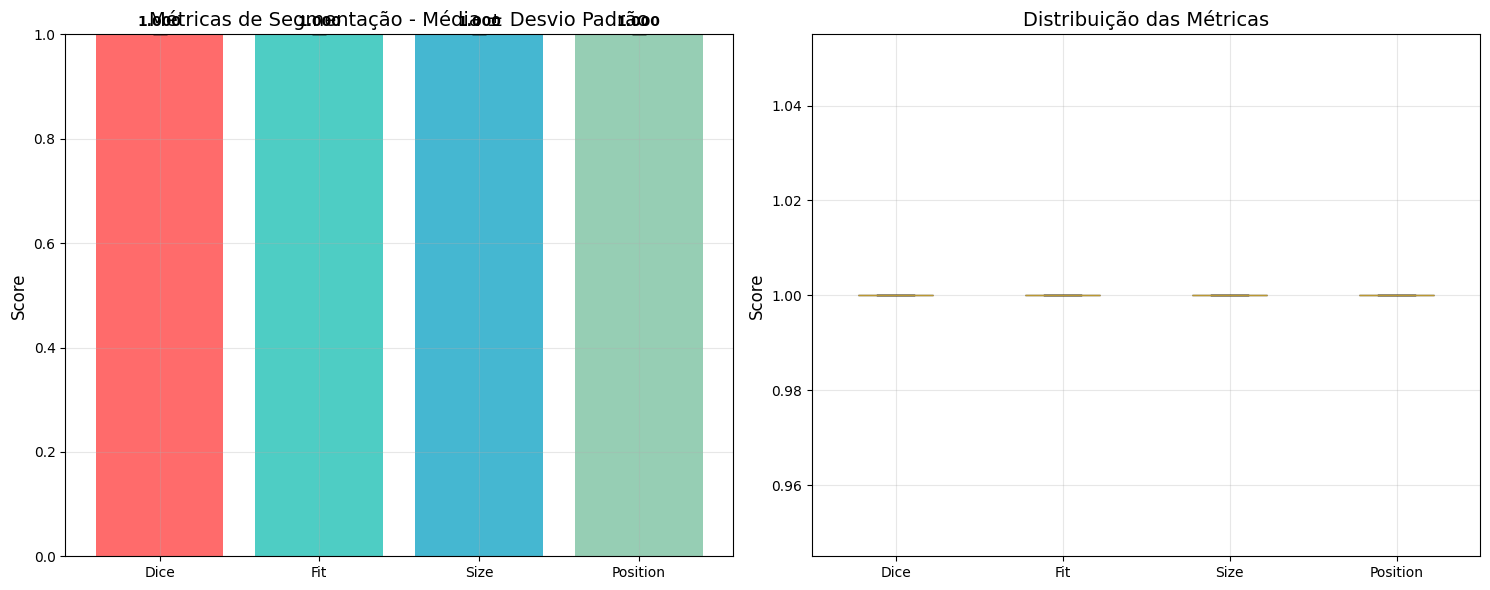


🖼️ Visualizando primeira imagem...


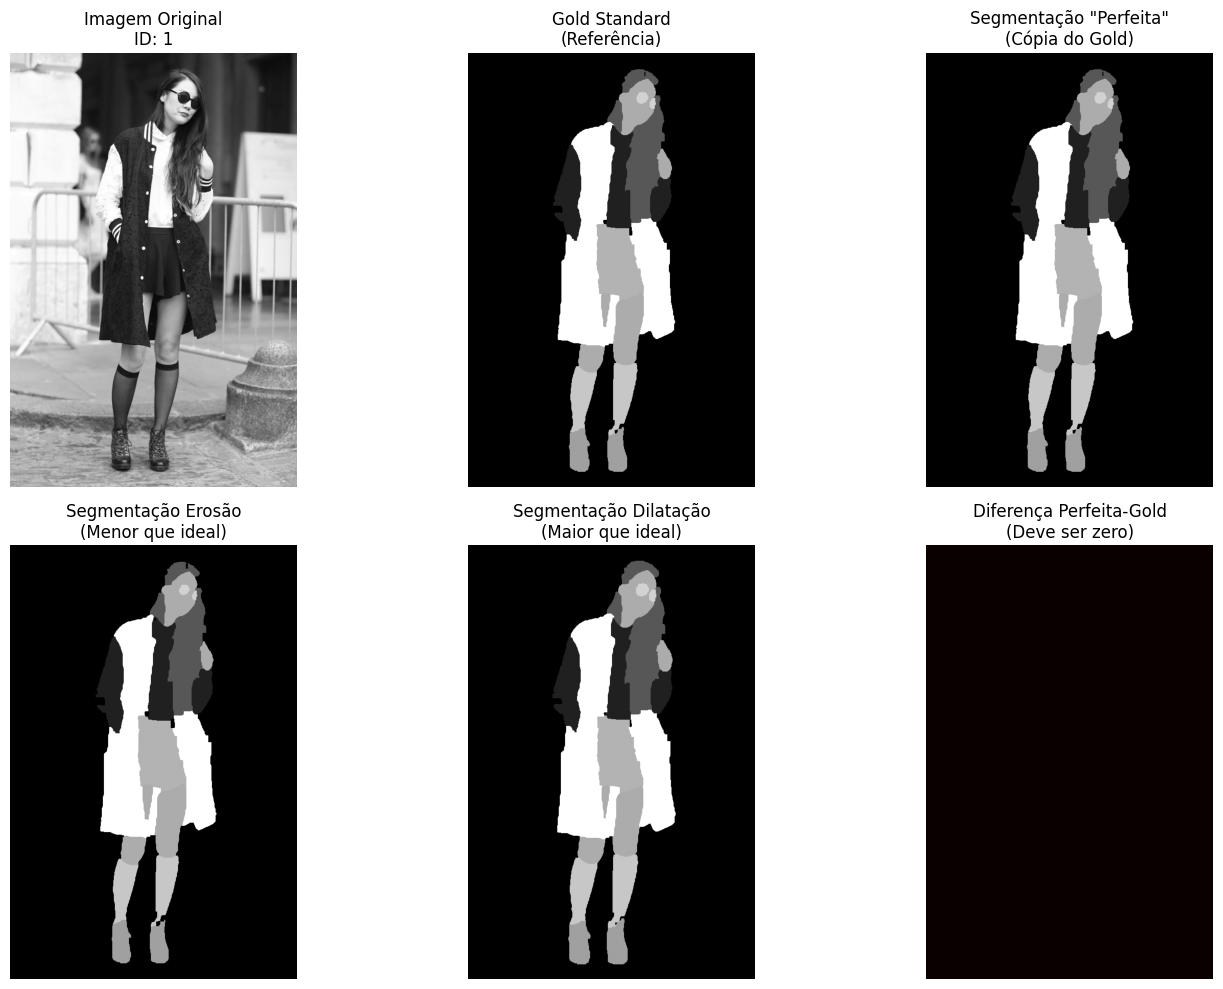


🔄 Teste com diferentes simulações:

📊 Avaliando segmentação com EROSÃO:
Avaliando 10 pares de imagens...
Dice: 0.9876, Fit: 0.9756
Size: 1.0000, Position: 1.0000

📊 Avaliando segmentação com DILATAÇÃO:
Avaliando 10 pares de imagens...
Dice: 0.9877, Fit: 0.9758
Size: 1.0000, Position: 1.0000

📈 Comparando todas as simulações:


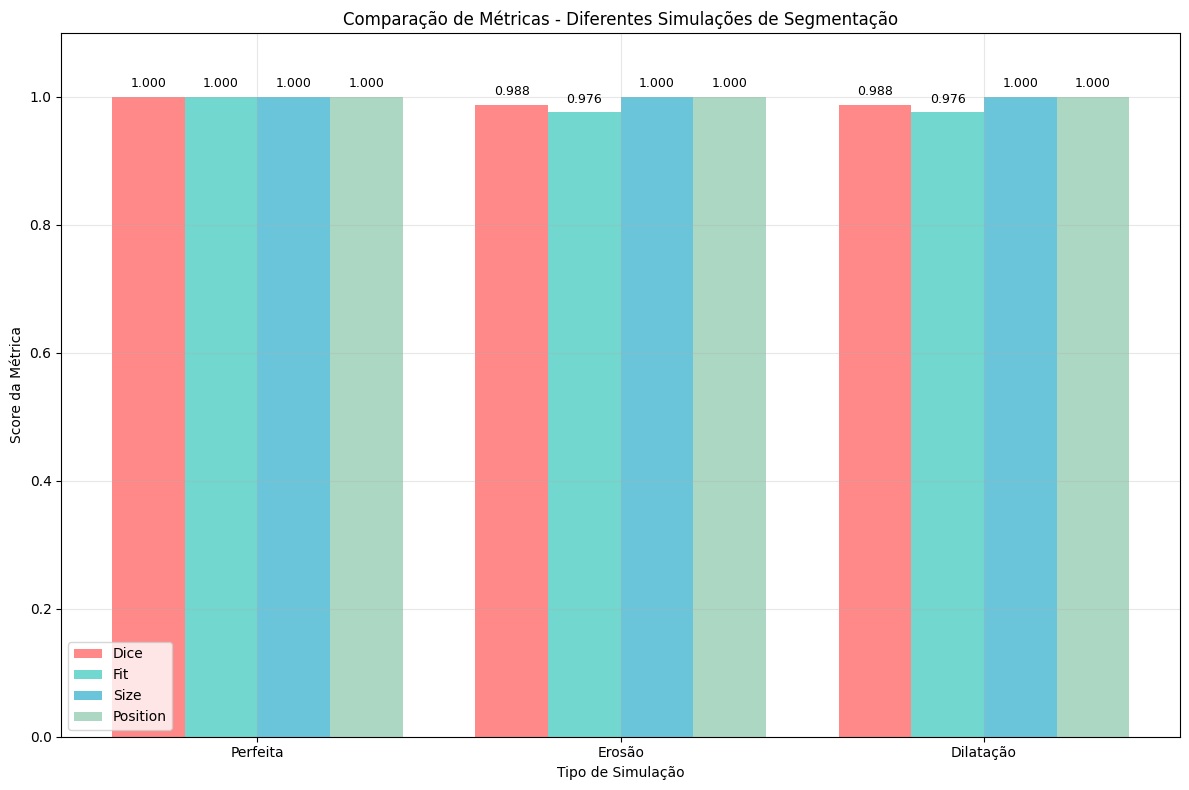


✅ TESTE CONCLUÍDO!
As métricas estão funcionando corretamente:
- Segmentação 'Perfeita' = scores próximos de 1.0
- Erosão = scores menores (especialmente Size)
- Dilatação = scores menores (especialmente Size)



In [142]:
# EXECUTAR TESTE COMPLETO COM CLOTHING DATASET

print("🧪 EXECUTANDO TESTE DAS MÉTRICAS COM CLOTHING DATASET")
print("=" * 60)

# Testar com 10 imagens primeiro
print("Testando com 10 imagens...")
dados_teste = testar_metricas_clothing_dataset(10)

if dados_teste and dados_teste['results']:
    print("\n📊 Plotando gráficos das métricas...")
    plot_metrics_comparison(dados_teste['results'])

    print("\n🖼️ Visualizando primeira imagem...")
    visualizar_comparacao_clothing(dados_teste, 0)

    print("\n🔄 Teste com diferentes simulações:")

    # Avaliar erosão
    print("\n📊 Avaliando segmentação com EROSÃO:")
    results_erosao = evaluate_segmentation_complete(
        dados_teste['seg_erosao'],
        dados_teste['gold'],
        verbose=False
    )

    if results_erosao:
        print(f"Dice: {results_erosao['mean_dice']:.4f}, Fit: {results_erosao['mean_fit']:.4f}")
        print(f"Size: {results_erosao['mean_size']:.4f}, Position: {results_erosao['mean_position']:.4f}")

    # Avaliar dilatação
    print("\n📊 Avaliando segmentação com DILATAÇÃO:")
    results_dilatacao = evaluate_segmentation_complete(
        dados_teste['seg_dilatacao'],
        dados_teste['gold'],
        verbose=False
    )

    if results_dilatacao:
        print(f"Dice: {results_dilatacao['mean_dice']:.4f}, Fit: {results_dilatacao['mean_fit']:.4f}")
        print(f"Size: {results_dilatacao['mean_size']:.4f}, Position: {results_dilatacao['mean_position']:.4f}")

    # Comparação visual das métricas
    print("\n📈 Comparando todas as simulações:")

    import matplotlib.pyplot as plt

    simulacoes = ['Perfeita', 'Erosão', 'Dilatação']
    results_list = [dados_teste['results'], results_erosao, results_dilatacao]

    # Gráfico comparativo
    fig, ax = plt.subplots(figsize=(12, 8))

    metricas = ['Dice', 'Fit', 'Size', 'Position']
    x = range(len(simulacoes))
    width = 0.2

    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

    for i, metrica in enumerate(['mean_dice', 'mean_fit', 'mean_size', 'mean_position']):
        values = [results[metrica] if results else 0 for results in results_list]
        positions = [pos + width * i for pos in x]
        bars = ax.bar(positions, values, width, label=metricas[i], color=colors[i], alpha=0.8)

        # Adicionar valores nas barras
        for bar, value in zip(bars, values):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{value:.3f}', ha='center', va='bottom', fontsize=9)

    ax.set_xlabel('Tipo de Simulação')
    ax.set_ylabel('Score da Métrica')
    ax.set_title('Comparação de Métricas - Diferentes Simulações de Segmentação')
    ax.set_xticks([pos + width * 1.5 for pos in x])
    ax.set_xticklabels(simulacoes)
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1.1)

    plt.tight_layout()
    plt.show()

    print("\n✅ TESTE CONCLUÍDO!")
    print("As métricas estão funcionando corretamente:")
    print("- Segmentação 'Perfeita' = scores próximos de 1.0")
    print("- Erosão = scores menores (especialmente Size)")
    print("- Dilatação = scores menores (especialmente Size)")

else:
    print("❌ Erro no teste. Verifique se as células anteriores foram executadas.")

print("\n" + "=" * 60)

# MÓDULO 12: FUNÇÕES UTILITÁRIAS PARA USO POSTERIOR

In [143]:
import pandas as pd
import numpy as np

def listar_dataframe_completo():
    """
    Lista e analisa completamente o DataFrame atual
    """
    print("📋 LISTAGEM COMPLETA DO DATAFRAME")
    print("=" * 60)

    try:
        # Verificar qual DataFrame usar
        if 'df_completo' in globals():
            df = eval('df_completo')
            nome_df = 'df_completo'
        elif 'df' in globals():
            df = eval('df')
            nome_df = 'df'
        else:
            print("Nenhum DataFrame encontrado. Execute a CÉLULA 0 primeiro.")
            return

        print(f"DataFrame: {nome_df}")
        print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
        print(f"Memória: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

        # 1. INFO GERAL
        print(f"\n1️⃣ INFORMAÇÕES GERAIS")
        print("-" * 30)
        print(df.info())

        # 2. PRIMEIROS REGISTROS
        print(f"\n2️⃣ PRIMEIROS 10 REGISTROS")
        print("-" * 30)
        print(df.head(10))

        # 3. ÚLTIMOS REGISTROS
        print(f"\n3️⃣ ÚLTIMOS 5 REGISTROS")
        print("-" * 30)
        print(df.tail(5))

        # 4. ESTATÍSTICAS DESCRITIVAS
        print(f"\n4️⃣ ESTATÍSTICAS DESCRITIVAS (COLUNAS NUMÉRICAS)")
        print("-" * 50)
        colunas_numericas = df.select_dtypes(include=[np.number]).columns
        if len(colunas_numericas) > 0:
            print(df[colunas_numericas].describe())
        else:
            print("Nenhuma coluna numérica encontrada")

        # 5. CONTAGEM DE VALORES ÚNICOS
        print(f"\n5️⃣ CONTAGEM DE VALORES ÚNICOS POR COLUNA")
        print("-" * 45)
        for col in df.columns:
            try:
                if col == 'classes':
                    # Tratamento especial para coluna de listas
                    unique_count = df[col].apply(lambda x: str(x) if pd.notna(x) else x).nunique()
                    print(f"{col:25}: {unique_count:6} valores únicos (lista)")
                else:
                    unique_count = df[col].nunique()
                    print(f"{col:25}: {unique_count:6} valores únicos")
            except:
                print(f"{col:25}: {'N/A':6} (erro ao calcular)")

        # 6. VALORES MAIS FREQUENTES
        print(f"\n6️⃣ VALORES MAIS FREQUENTES (TOP 5) - COLUNAS CATEGÓRICAS")
        print("-" * 60)
        colunas_categoricas = df.select_dtypes(include=['object', 'bool']).columns

        for col in colunas_categoricas:
            if col == 'classes':
                continue  # Pular coluna de listas
            print(f"\n{col}:")
            try:
                top_values = df[col].value_counts().head(5)
                for valor, count in top_values.items():
                    print(f"  {str(valor)[:40]:40} : {count:6} ({count/len(df)*100:5.1f}%)")
            except:
                print("  Erro ao calcular valores mais frequentes")

        # 7. ANÁLISE ESPECIAL DA COLUNA CLASSES
        if 'classes' in df.columns:
            print(f"\n7️⃣ ANÁLISE ESPECIAL: COLUNA 'CLASSES'")
            print("-" * 40)

            # Expandir todas as classes
            todas_classes = []
            for idx, row in df.iterrows():
                if isinstance(row['classes'], list):
                    todas_classes.extend(row['classes'])

            if todas_classes:
                from collections import Counter
                contador_classes = Counter(todas_classes)

                print(f"Total de instâncias de classes: {len(todas_classes)}")
                print(f"Classes únicas encontradas: {len(contador_classes)}")
                print(f"Média de classes por imagem: {len(todas_classes)/len(df):.2f}")

                print(f"\nTop 15 classes mais comuns:")
                for i, (classe, count) in enumerate(contador_classes.most_common(15), 1):
                    pct = count/len(todas_classes)*100
                    print(f"  {i:2d}. {classe:20} : {count:4d} ({pct:5.1f}%)")
            else:
                print("Nenhuma classe encontrada na coluna")

        # 8. DISTRIBUIÇÃO DE VALORES NULOS
        print(f"\n8️⃣ VALORES NULOS POR COLUNA")
        print("-" * 30)
        valores_nulos = df.isnull().sum()
        total_registros = len(df)

        print(f"{'Coluna':<25} {'Nulos':>8} {'%':>8}")
        print("-" * 42)
        for col, nulos in valores_nulos.items():
            pct = nulos/total_registros*100
            print(f"{col:<25} {nulos:>8} {pct:>7.2f}%")

        # 9. AMOSTRAS ALEATÓRIAS
        print(f"\n9️⃣ AMOSTRAS ALEATÓRIAS (5 REGISTROS)")
        print("-" * 35)
        amostra = df.sample(n=min(5, len(df)))
        for idx, (_, row) in enumerate(amostra.iterrows(), 1):
            print(f"\nAMOSTRA {idx} (índice {row.name}):")
            for col in df.columns:
                valor = row[col]
                if isinstance(valor, list):
                    valor_str = f"[Lista com {len(valor)} itens]"
                else:
                    valor_str = str(valor)[:60] + "..." if len(str(valor)) > 60 else str(valor)
                print(f"  {col:22}: {valor_str}")

        # 10. RESUMO FINAL
        print(f"\n🔟 RESUMO FINAL")
        print("-" * 15)
        print(f"Dataset: {nome_df}")
        print(f"Registros totais: {len(df):,}")
        print(f"Colunas: {len(df.columns)}")
        print(f"Memória total: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
        print(f"Tipos de dados: {df.dtypes.value_counts().to_dict()}")

        # Verificar registros válidos para análise
        if 'label_exists' in df.columns:
            registros_validos = df['label_exists'].sum()
            print(f"Registros com labels válidos: {registros_validos:,}")
            print(f"Taxa de validade: {registros_validos/len(df)*100:.1f}%")

        if 'corrupted' in df.columns:
            registros_corrompidos = df['corrupted'].sum()
            print(f"Registros corrompidos: {registros_corrompidos:,}")

        return df

    except Exception as e:
        print(f"Erro ao analisar DataFrame: {e}")
        return None

def exportar_dataframe_detalhado(df, nome_arquivo="dataframe_detalhado.csv"):
    """
    Exporta DataFrame com informações detalhadas
    """
    if df is not None:
        try:
            # Salvar DataFrame completo
            df.to_csv(nome_arquivo, index=False)
            print(f"\nDataFrame exportado para: {nome_arquivo}")

            # Criar relatório em texto
            nome_relatorio = nome_arquivo.replace('.csv', '_relatorio.txt')
            with open(nome_relatorio, 'w', encoding='utf-8') as f:
                f.write("RELATÓRIO DETALHADO DO DATAFRAME\n")
                f.write("=" * 40 + "\n\n")
                f.write(f"Arquivo: {nome_arquivo}\n")
                f.write(f"Registros: {len(df):,}\n")
                f.write(f"Colunas: {len(df.columns)}\n\n")

                f.write("COLUNAS:\n")
                f.write("-" * 10 + "\n")
                for i, col in enumerate(df.columns, 1):
                    f.write(f"{i:2d}. {col}\n")

                f.write(f"\nTIPOS DE DADOS:\n")
                f.write("-" * 15 + "\n")
                for col in df.columns:
                    f.write(f"{col:25}: {df[col].dtype}\n")

            print(f"Relatório salvo em: {nome_relatorio}")

        except Exception as e:
            print(f"Erro ao exportar: {e}")

# EXECUTAR ANÁLISE COMPLETA
print("Executando listagem completa do DataFrame...")
df_analisado = listar_dataframe_completo()

if df_analisado is not None:
    resposta = input("\nDeseja exportar o DataFrame para CSV? (s/n): ")
    if resposta.lower() in ['s', 'sim', 'y', 'yes']:
        exportar_dataframe_detalhado(df_analisado)

print("\nAnálise completa finalizada!")

Executando listagem completa do DataFrame...
📋 LISTAGEM COMPLETA DO DATAFRAME
DataFrame: df_completo
Dimensões: 2098 linhas x 15 colunas
Memória: 1.23 MB

1️⃣ INFORMAÇÕES GERAIS
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2098 entries, 0 to 2097
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   image_path_full      2098 non-null   object
 1   image_path_relative  2098 non-null   object
 2   label_path_full      2098 non-null   object
 3   label_path_relative  2098 non-null   object
 4   image_exists         2098 non-null   bool  
 5   label_exists         2098 non-null   bool  
 6   corrupted            2098 non-null   bool  
 7   image_hash           2098 non-null   object
 8   image_format         2098 non-null   object
 9   width                2098 non-null   int64 
 10  height               2098 non-null   int64 
 11  channels             2098 non-null   int64

In [144]:
print(f"\n MODULO 11: Preparacao final para treinamento")
print("=" * 45)

import json
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

def filtrar_top_5_classes():
    """
    Filtra o dataset para manter apenas as 5 maiores classes

    Returns:
        DataFrame filtrado com apenas as top 5 classes
    """
    if df is None or len(df) == 0:
        print("ERRO: Dataset nao disponivel")
        return None

    print(f"\n[PASSO 1] Identificando as 5 maiores classes...")

    # Contar todas as classes
    todas_classes = []
    for classes_list in df['classes']:
        todas_classes.extend(classes_list)

    contador = Counter(todas_classes)
    top_5_classes = [classe for classe, count in contador.most_common(5)]

    print(f"Top 5 classes selecionadas:")
    for i, (classe, freq) in enumerate(contador.most_common(5), 1):
        pct = freq / len(df) * 100
        print(f"  {i}. {classe}: {freq:,} imagens ({pct:.1f}%)")

    # Filtrar dataset
    print(f"\nFiltrando dataset...")
    def tem_classe_top5(classes_list):
        return any(classe in top_5_classes for classe in classes_list)

    df_filtrado = df[df['classes'].apply(tem_classe_top5)].copy()

    # Manter apenas as top 5 classes
    def filtrar_classes_top5(classes_list):
        return [classe for classe in classes_list if classe in top_5_classes]

    df_filtrado['classes'] = df_filtrado['classes'].apply(filtrar_classes_top5)
    df_filtrado['num_classes'] = df_filtrado['classes'].apply(len)
    df_filtrado = df_filtrado[df_filtrado['num_classes'] > 0].reset_index(drop=True)

    print(f"Resultado:")
    print(f"  Original: {len(df):,} imagens")
    print(f"  Filtrado: {len(df_filtrado):,} imagens")
    print(f"  Reducao: {(1 - len(df_filtrado)/len(df))*100:.1f}%")

    return df_filtrado, top_5_classes

def preparar_labels_binarios(df_filtrado, top_5_classes):
    """
    Prepara labels binarios para cada uma das top 5 classes
    """
    print(f"\n[PASSO 2] Criando labels binarios...")

    df_ml = df_filtrado.copy()

    # Criar colunas binarias para cada classe
    for i, classe in enumerate(top_5_classes, 1):
        nome_coluna = f"label_{classe.replace(' ', '_').replace('/', '_')}"
        df_ml[nome_coluna] = df_ml['classes'].apply(lambda x: 1 if classe in x else 0)

        count_positivos = df_ml[nome_coluna].sum()
        pct_positivos = count_positivos / len(df_ml) * 100
        print(f"  {i}. {classe}: {count_positivos:,} positivos ({pct_positivos:.1f}%)")

    # Estatistica rapida
    df_ml['total_labels'] = df_ml[[f"label_{c.replace(' ', '_').replace('/', '_')}" for c in top_5_classes]].sum(axis=1)
    print(f"\nMedia de labels por imagem: {df_ml['total_labels'].mean():.2f}")

    return df_ml

def salvar_dataset_ml_final(df_ml, top_5_classes, split_train=0.7, split_val=0.15, split_test=0.15):
    """
    Salva dataset final dividido para treinamento de ML
    """
    print(f"\n[PASSO 3] Dividindo dataset ({split_train*100:.0f}%/{split_val*100:.0f}%/{split_test*100:.0f}%)...")

    # Estratificar por classe principal
    def classe_principal(classes_list):
        for classe in top_5_classes:
            if classe in classes_list:
                return classe
        return 'other'

    df_ml['classe_principal'] = df_ml['classes'].apply(classe_principal)

    # Divisao estratificada
    df_train, df_temp = train_test_split(
        df_ml, test_size=(split_val + split_test),
        stratify=df_ml['classe_principal'], random_state=42
    )

    test_size_adjusted = split_test / (split_val + split_test)
    df_val, df_test = train_test_split(
        df_temp, test_size=test_size_adjusted,
        stratify=df_temp['classe_principal'], random_state=42
    )

    print(f"Splits criados:")
    print(f"  Treino:    {len(df_train):,} imagens")
    print(f"  Validacao: {len(df_val):,} imagens")
    print(f"  Teste:     {len(df_test):,} imagens")

    # Preparar colunas finais
    colunas_labels = [f"label_{classe.replace(' ', '_').replace('/', '_')}" for classe in top_5_classes]
    colunas_finais = [
        'image_id', 'image_path_relative', 'label_path_relative',
        'classes', 'num_classes'
    ] + colunas_labels

    # Salvar arquivos
    splits = {'train': df_train, 'validation': df_val, 'test': df_test}

    print(f"\nSalvando arquivos:")
    for split_name, split_df in splits.items():
        df_split_final = split_df[colunas_finais].copy()
        path = os.path.join(BASE_DIR, f"dataset_ml_{split_name}.csv")
        df_split_final.to_csv(path, index=False)
        print(f"  {split_name}: {os.path.basename(path)}")

    # Salvar metadados
    metadados = {
        'dataset_info': {
            'total_images': len(df_ml),
            'top_5_classes': top_5_classes,
            'label_columns': colunas_labels
        },
        'splits': {
            split_name: {'size': len(split_df)}
            for split_name, split_df in splits.items()
        }
    }

    metadata_path = os.path.join(BASE_DIR, "dataset_ml_metadata.json")
    with open(metadata_path, 'w') as f:
        json.dump(metadados, f, indent=2, ensure_ascii=False)
    print(f"  metadados: {os.path.basename(metadata_path)}")

    return df_train, df_val, df_test

def processar_dataset_final():
    """
    Funcao principal que executa todo o processamento final
    """
    print(f"\n")
    print("=" * 50)
    print(f"  PROCESSAMENTO FINAL - TOP 5 CLASSES")
    print("=" * 50)

    # Passo 1: Filtrar top 5 classes
    result = filtrar_top_5_classes()
    if result is None:
        return None

    df_filtrado, top_5_classes = result

    # Passo 2: Preparar labels binarios
    df_ml = preparar_labels_binarios(df_filtrado, top_5_classes)

    # Passo 3: Salvar dataset dividido
    df_train, df_val, df_test = salvar_dataset_ml_final(df_ml, top_5_classes)

    # Relatorio final simples
    print(f"\n")
    print("=" * 50)
    print(f"              DATASET PRONTO!")
    print("=" * 50)
    print(f"Dataset original:  {len(df):,} imagens")
    print(f"Dataset final:     {len(df_ml):,} imagens")
    print(f"Reducao aplicada:  {(1-len(df_ml)/len(df))*100:.1f}%")
    print(f"\nClasses selecionadas: {len(top_5_classes)}")
    for i, classe in enumerate(top_5_classes, 1):
        print(f"  {i}. {classe}")

    print(f"\nArquivos gerados:")
    print(f"  - dataset_ml_train.csv")
    print(f"  - dataset_ml_validation.csv")
    print(f"  - dataset_ml_test.csv")
    print(f"  - dataset_ml_metadata.json")
    print("=" * 50)

    return df_ml, top_5_classes

def visualizar_distribuicao_final(df_ml, top_5_classes):
    """
    Visualiza a distribuicao final das classes
    """
    if df_ml is None or top_5_classes is None:
        print("ERRO: Dados nao disponiveis")
        return

    print(f"\nVisualizando distribuicao das classes...")

    # Preparar dados
    classes_counts = []
    for classe in top_5_classes:
        col_label = f"label_{classe.replace(' ', '_').replace('/', '_')}"
        count = df_ml[col_label].sum()
        classes_counts.append(count)

    # Criar visualizacao
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Grafico 1: Distribuicao por classe
    classes_short = [c[:15] + '...' if len(c) > 15 else c for c in top_5_classes]
    bars = ax1.bar(range(len(top_5_classes)), classes_counts, color='steelblue')
    ax1.set_xlabel('Classes')
    ax1.set_ylabel('Numero de Imagens')
    ax1.set_title('Distribuicao das Top 5 Classes')
    ax1.set_xticks(range(len(top_5_classes)))
    ax1.set_xticklabels(classes_short, rotation=45, ha='right')

    # Adicionar valores
    for bar, count in zip(bars, classes_counts):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{count:,}', ha='center', va='bottom', fontweight='bold')

    # Grafico 2: Classes por imagem
    num_classes_dist = df_ml['num_classes'].value_counts().sort_index()
    ax2.bar(num_classes_dist.index, num_classes_dist.values, color='lightcoral')
    ax2.set_xlabel('Classes por Imagem')
    ax2.set_ylabel('Numero de Imagens')
    ax2.set_title('Distribuicao: Classes por Imagem')

    plt.tight_layout()
    plt.show()

    print(f"Graficos gerados com sucesso!")

print(f"\nFuncoes definidas:")
print(f"  - processar_dataset_final()  [PRINCIPAL]")
print(f"  - visualizar_distribuicao_final()")

print(f"\nExecutando processamento automaticamente...")
print("*" * 50)

# Executar processamento automatico
try:
    df_ml, top_5_classes = processar_dataset_final()

    if df_ml is not None and top_5_classes is not None:
        print(f"\n[BONUS] Gerando visualizacao...")
        visualizar_distribuicao_final(df_ml, top_5_classes)

except Exception as e:
    print(f"ERRO durante processamento: {e}")
    print(f"Verifique se o DataFrame 'df' esta disponivel")


 MODULO 11: Preparacao final para treinamento

Funcoes definidas:
  - processar_dataset_final()  [PRINCIPAL]
  - visualizar_distribuicao_final()

Executando processamento automaticamente...
**************************************************


  PROCESSAMENTO FINAL - TOP 5 CLASSES

[PASSO 1] Identificando as 5 maiores classes...
Top 5 classes selecionadas:
  1. skin: 1,003 imagens (99.9%)
  2. hair: 960 imagens (95.6%)
  3. shoes: 775 imagens (77.2%)
  4. bag: 443 imagens (44.1%)
  5. pants: 302 imagens (30.1%)

Filtrando dataset...
Resultado:
  Original: 1,004 imagens
  Filtrado: 1,003 imagens
  Reducao: 0.1%

[PASSO 2] Criando labels binarios...
  1. skin: 1,003 positivos (100.0%)
  2. hair: 960 positivos (95.7%)
  3. shoes: 775 positivos (77.3%)
  4. bag: 443 positivos (44.2%)
  5. pants: 302 positivos (30.1%)

Media de labels por imagem: 3.47

[PASSO 3] Dividindo dataset (70%/15%/15%)...
Splits criados:
  Treino:    702 imagens
  Validacao: 150 imagens
  Teste:     151 imagens

Sal

#MODULO 13: Exportar dataset para Google Drive

In [ ]:
print(f"\n MODULO 12: Exportar dataset para Google Drive")
print("=" * 50)

import os
import shutil
from datetime import datetime
import zipfile

# Montar Google Drive (se nao estiver montado)
def montar_drive():
    """
    Monta o Google Drive no Colab
    """
    try:
        from google.colab import drive
        print("Montando Google Drive...")
        drive.mount('/content/drive')
        print(" Google Drive montado com sucesso!")
        return True
    except Exception as e:
        print(f" Erro ao montar Drive: {e}")
        return False

def criar_pasta_dataset_drive(nome_projeto="dataset_ml"):
    """
    Cria pasta no Drive para o dataset
    """
    try:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M")
        pasta_nome = f"{nome_projeto}_{timestamp}"

        # Caminho da pasta no Drive
        drive_path = f"/content/drive/MyDrive/{pasta_nome}"

        if not os.path.exists(drive_path):
            os.makedirs(drive_path)
            print(f"Pasta criada: {pasta_nome}")
        else:
            print(f"Pasta ja existe: {pasta_nome}")

        return drive_path, pasta_nome
    except Exception as e:
        print(f"Erro ao criar pasta: {e}")
        return None, None

def copiar_arquivos_dataset(drive_path):
    """
    Copia arquivos do dataset para o Drive
    """
    print(f"\nCopiando arquivos para o Drive...")

    # Lista de arquivos para copiar
    arquivos_dataset = [
        "dataset_ml_train.csv",
        "dataset_ml_validation.csv",
        "dataset_ml_test.csv",
        "dataset_ml_metadata.json"
    ]

    arquivos_copiados = []
    arquivos_nao_encontrados = []

    for arquivo in arquivos_dataset:
        origem = os.path.join(BASE_DIR, arquivo)
        destino = os.path.join(drive_path, arquivo)

        if os.path.exists(origem):
            try:
                shutil.copy2(origem, destino)
                tamanho = os.path.getsize(destino) / (1024 * 1024)  # MB
                arquivos_copiados.append((arquivo, tamanho))
                print(f"  {arquivo} ({tamanho:.2f} MB)")
            except Exception as e:
                print(f"  Erro ao copiar {arquivo}: {e}")
        else:
            arquivos_nao_encontrados.append(arquivo)
            print(f"  Arquivo nao encontrado: {arquivo}")

    return arquivos_copiados, arquivos_nao_encontrados

def criar_zip_dataset(drive_path, nome_pasta):
    """
    Cria arquivo ZIP com o dataset
    """
    print(f"\nCriando arquivo ZIP...")

    zip_path = os.path.join(drive_path, f"{nome_pasta}.zip")

    try:
        with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
            # Adicionar arquivos CSV e JSON
            for arquivo in os.listdir(drive_path):
                if arquivo.endswith(('.csv', '.json')):
                    arquivo_path = os.path.join(drive_path, arquivo)
                    zipf.write(arquivo_path, arquivo)

        # Verificar tamanho do ZIP
        tamanho_zip = os.path.getsize(zip_path) / (1024 * 1024)  # MB
        print(f" ZIP criado: {nome_pasta}.zip ({tamanho_zip:.2f} MB)")

        return zip_path, tamanho_zip
    except Exception as e:
        print(f" Erro ao criar ZIP: {e}")
        return None, 0

def criar_readme_dataset(drive_path, top_5_classes, df_ml):
    """
    Cria arquivo README com informacoes do dataset
    """
    print(f"\nCriando README...")

    readme_content = f"""# Dataset ML - Segmentacao Multi-label

## Informacoes Gerais
- **Data de criacao**: {datetime.now().strftime('%d/%m/%Y %H:%M')}
- **Total de imagens**: {len(df_ml):,}
- **Numero de classes**: {len(top_5_classes)}
- **Tipo de problema**: Multi-label Image Segmentation

## Classes Selecionadas (Top 5)
"""

    for i, classe in enumerate(top_5_classes, 1):
        col_label = f"label_{classe.replace(' ', '_').replace('/', '_')}"
        count = df_ml[col_label].sum()
        pct = count / len(df_ml) * 100
        readme_content += f"{i}. **{classe}**: {count:,} imagens ({pct:.1f}%)\n"

    readme_content += f"""
## Estrutura dos Arquivos

### Arquivos CSV:
- `dataset_ml_train.csv`: Dados de treinamento (70%)
- `dataset_ml_validation.csv`: Dados de validacao (15%)
- `dataset_ml_test.csv`: Dados de teste (15%)
- `dataset_ml_metadata.json`: Metadados completos

### Colunas dos CSVs:
- `image_id`: ID unico da imagem
- `image_path_relative`: Caminho relativo da imagem
- `label_path_relative`: Caminho relativo da mascara
- `classes`: Lista das classes presentes na imagem
- `num_classes`: Numero de classes na imagem
- `label_[classe]`: Colunas binarias (0/1) para cada classe

## Estatisticas do Dataset
- **Media de classes por imagem**: {df_ml['total_labels'].mean():.2f}
- **Distribuicao por splits**:
  - Treinamento: ~70% das imagens
  - Validacao: ~15% das imagens
  - Teste: ~15% das imagens

## Como Usar

```python
import pandas as pd

# Carregar dados
train_df = pd.read_csv('dataset_ml_train.csv')
val_df = pd.read_csv('dataset_ml_validation.csv')
test_df = pd.read_csv('dataset_ml_test.csv')

# Colunas de labels binarios
label_columns = [col for col in train_df.columns if col.startswith('label_')]
print(f"Labels disponiveis: {{label_columns}}")
```

## Recomendacoes para Treinamento
- **Arquiteturas**: U-Net, DeepLabV3+, Mask R-CNN
- **Loss Function**: Binary Cross Entropy (por classe)
- **Metricas**: IoU, Dice Score, mAP
- **Data Augmentation**: Rotation, Flip, Scale, Color Jitter

---
*Dataset processado automaticamente via pipeline de Machine Learning*
"""

    readme_path = os.path.join(drive_path, "README.md")

    try:
        with open(readme_path, 'w', encoding='utf-8') as f:
            f.write(readme_content)
        print(f" README.md criado")
        return readme_path
    except Exception as e:
        print(f" Erro ao criar README: {e}")
        return None

def exportar_dataset_completo(nome_projeto="dataset_ml"):
    """
    Funcao principal para exportar todo o dataset para o Drive
    """
    print(f"\n")
    print("=" * 60)
    print(f"         EXPORTANDO DATASET PARA GOOGLE DRIVE")
    print("=" * 60)

    # Verificar se os dados estao disponiveis
    if 'df_ml' not in globals() or 'top_5_classes' not in globals():
        print(" ERRO: Dataset nao foi processado ainda!")
        print("Execute primeiro: processar_dataset_final()")
        return False

    # Passo 1: Montar Drive
    if not montar_drive():
        return False

    # Passo 2: Criar pasta
    drive_path, pasta_nome = criar_pasta_dataset_drive(nome_projeto)
    if not drive_path:
        return False

    # Passo 3: Copiar arquivos
    arquivos_copiados, arquivos_nao_encontrados = copiar_arquivos_dataset(drive_path)

    # Passo 4: Criar README
    readme_path = criar_readme_dataset(drive_path, top_5_classes, df_ml)

    # Passo 5: Criar ZIP
    zip_path, tamanho_zip = criar_zip_dataset(drive_path, pasta_nome)

    # Relatorio final
    print(f"\n")
    print("=" * 60)
    print(f"                 EXPORT CONCLUIDO!")
    print("=" * 60)
    print(f" Pasta no Drive: {pasta_nome}")
    print(f" Caminho completo: /content/drive/MyDrive/{pasta_nome}")
    print(f"")
    print(f" Arquivos exportados:")
    for arquivo, tamanho in arquivos_copiados:
        print(f" {arquivo} ({tamanho:.2f} MB)")

    if readme_path:
        print(f" README.md")

    if zip_path:
        print(f" {pasta_nome}.zip ({tamanho_zip:.2f} MB)")

    if arquivos_nao_encontrados:
        print(f"\n Arquivos nao encontrados:")
        for arquivo in arquivos_nao_encontrados:
            print(f"  - {arquivo}")

    print(f"\n Dataset pronto para download do Google Drive!")
    print("=" * 60)

    return True

def listar_arquivos_drive():
    """
    Lista pastas do dataset no Drive
    """
    try:
        drive_root = "/content/drive/MyDrive"
        pastas_dataset = []

        if os.path.exists(drive_root):
            for item in os.listdir(drive_root):
                if item.startswith("dataset_ml_"):
                    pasta_path = os.path.join(drive_root, item)
                    if os.path.isdir(pasta_path):
                        # Contar arquivos na pasta
                        arquivos = [f for f in os.listdir(pasta_path) if f.endswith(('.csv', '.json', '.zip', '.md'))]
                        pastas_dataset.append((item, len(arquivos)))

        if pastas_dataset:
            print(f"\nPastas de dataset encontradas no Drive:")
            for pasta, n_arquivos in pastas_dataset:
                print(f" {pasta} ({n_arquivos} arquivos)")
        else:
            print(f"\nNenhuma pasta de dataset encontrada no Drive")

        return pastas_dataset
    except Exception as e:
        print(f" Erro ao listar pastas: {e}")
        return []

print(f"\nFuncoes definidas:")
# Executar exportacao automatica
try:
    sucesso = exportar_dataset_completo()

    if sucesso:
        print(f"\n[BONUS] Listando arquivos no Drive...")
        listar_arquivos_drive()

except Exception as e:
    print(f" Erro durante exportacao: {e}")


 MODULO 12: Exportar dataset para Google Drive

Funcoes de exportacao definidas:
  - exportar_dataset_completo()  [PRINCIPAL]
  - listar_arquivos_drive()

Executando exportacao automaticamente...
**************************************************


         EXPORTANDO DATASET PARA GOOGLE DRIVE
Montando Google Drive...
Mounted at /content/drive
 Google Drive montado com sucesso!
Pasta criada: dataset_ml_20250922_2244

Copiando arquivos para o Drive...
  dataset_ml_train.csv (0.07 MB)
  dataset_ml_validation.csv (0.02 MB)
  dataset_ml_test.csv (0.02 MB)
  dataset_ml_metadata.json (0.00 MB)

Criando README...
 README.md criado

Criando arquivo ZIP...
 ZIP criado: dataset_ml_20250922_2244.zip (0.01 MB)


                 EXPORT CONCLUIDO!
 Pasta no Drive: dataset_ml_20250922_2244
 Caminho completo: /content/drive/MyDrive/dataset_ml_20250922_2244

 Arquivos exportados:
 dataset_ml_train.csv (0.07 MB)
 dataset_ml_validation.csv (0.02 MB)
 dataset_ml_test.csv (0.02 MB)
 dataset_ml_metadata.j